In [2]:
import pandas as pd
import numpy as np
import os
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import pickle
import umap
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2024-12-09 19:00:44.778017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 19:00:44.855469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 19:00:44.891856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 19:00:44.902203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 19:00:44.969853: I tensorflow/core/platform/cpu_feature_guar

In [3]:
path = "/media/guimcc/Elements/data_2"

# Load sales data
train_df = pd.read_csv(Path(path + '/train.csv'), parse_dates=['release_date'])
test_df = pd.read_csv(Path(path + '/test.csv'), parse_dates=['release_date'])

In [4]:
train_csv = pd.read_csv(Path(path + '/train.csv'), parse_dates=['release_date'])
test_csv = pd.read_csv(Path(path + '/test.csv'), parse_dates=['release_date'])

In [5]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


class ZeroShotDataset():
    def __init__(self, data_df, img_root, gtrends, cat_dict, col_dict, fab_dict, trend_len):
        self.data_df = data_df
        self.gtrends = gtrends
        self.cat_dict = cat_dict
        self.col_dict = col_dict
        self.fab_dict = fab_dict
        self.trend_len = trend_len
        self.img_root = img_root

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        return self.data_df.iloc[idx, :]

    def preprocess_data(self):
        data = self.data_df

        # Get the Gtrends time series associated with each product
        # Read the images (extracted image features) as well
        gtrends, image_features = [], []
        img_transforms = Compose([Resize((256, 256)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        for (idx, row) in tqdm(data.iterrows(), total=len(data), ascii=True):
            cat, col, fab, fiq_attr, start_date, img_path = row['category'], row['color'], row['fabric'], row['extra'], \
                row['release_date'], row['image_path']

            # Get the gtrend signal up to the previous year (52 weeks) of the release date
            gtrend_start = start_date - pd.DateOffset(weeks=52) # Set the initial date to 52 weeks before the release date
            cat_gtrend = self.gtrends.loc[gtrend_start:start_date][cat][-52:].values[:self.trend_len] # Get the last 52 weeks of the gtrend signal and "store - it" to each item
            col_gtrend = self.gtrends.loc[gtrend_start:start_date][col][-52:].values[:self.trend_len]
            fab_gtrend = self.gtrends.loc[gtrend_start:start_date][fab][-52:].values[:self.trend_len]

            cat_gtrend = MinMaxScaler().fit_transform(cat_gtrend.reshape(-1,1)).flatten() # Normalize the gtrend signals - all categories on the same scale
            col_gtrend = MinMaxScaler().fit_transform(col_gtrend.reshape(-1,1)).flatten()
            fab_gtrend = MinMaxScaler().fit_transform(fab_gtrend.reshape(-1,1)).flatten()
            multitrends =  np.vstack([cat_gtrend, col_gtrend, fab_gtrend])


            # Read images
            img = Image.open(os.path.join(self.img_root, img_path)).convert('RGB')

            # Append them to the lists
            gtrends.append(multitrends)
            image_features.append(img_transforms(img))

        # Convert to numpy arrays
        gtrends = np.array(gtrends)

        # Remove non-numerical information
        data.drop(['external_code', 'season', 'release_date', 'image_path'], axis=1, inplace=True)

        # Create tensors for each part of the input/output
        item_sales, temporal_features = torch.FloatTensor(data.iloc[:, :12].values), torch.FloatTensor(
            data.iloc[:, 13:17].values)
        categories, colors, fabrics = [self.cat_dict[val] for val in data.iloc[:].category.values], \
                                       [self.col_dict[val] for val in data.iloc[:].color.values], \
                                       [self.fab_dict[val] for val in data.iloc[:].fabric.values]

        
        categories, colors, fabrics = torch.LongTensor(categories), torch.LongTensor(colors), torch.LongTensor(fabrics)
        gtrends = torch.FloatTensor(gtrends)
        images = torch.stack(image_features)

        return TensorDataset(item_sales, categories, colors, fabrics, temporal_features, gtrends, images)

    def get_loader(self, batch_size, train=True):
        print('Starting dataset creation process...')
        data_with_gtrends = self.preprocess_data()
        data_loader = None
        if train:
            data_loader = DataLoader(data_with_gtrends, batch_size=batch_size, shuffle=True, num_workers=4)
        else:
            data_loader = DataLoader(data_with_gtrends, batch_size=1, shuffle=False, num_workers=4)
        print('Done.')

        return data_loader

In [6]:
from pathlib import Path

 # Load category and color encodings
cat_dict = torch.load(Path(path + '/category_labels.pt'))
col_dict = torch.load(Path(path + '/color_labels.pt'))
fab_dict = torch.load(Path(path + '/fabric_labels.pt'))

gtrends = pd.read_csv(Path(path + '/gtrends.csv'), index_col=[0], parse_dates=True)

/tmp/ipykernel_8120/1618174958.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cat_dict = torch.load(Path(path + '/category_labels.pt'))
/tmp/ipykernel_8120/1618174958.p

In [7]:
train_loader = ZeroShotDataset(train_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                   fab_dict, 52).get_loader(batch_size=32, train=True)
test_loader = ZeroShotDataset(test_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                  fab_dict, 52).get_loader(batch_size=1, train=False)

Starting dataset creation process...


100%|##########| 5080/5080 [02:54<00:00, 29.09it/s]


Done.
Starting dataset creation process...


100%|##########| 497/497 [00:20<00:00, 24.61it/s]

Done.


In [8]:
# Extract the data from the DataLoader for EDA
item_sales_list, categories_list, colors_list, fabrics_list, temporal_features_list, gtrends_list, images_list = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in train_loader:
    item_sales_list.append(item_sales_i.numpy())
    categories_list.append(categories_i.numpy())
    colors_list.append(colors_i.numpy())
    fabrics_list.append(fabrics_i.numpy())
    temporal_features_list.append(temporal_features_i.numpy())
    gtrends_list.append(gtrends_i.numpy())
    images_list.append(images_i.numpy())

# Convert lists to arrays for analysis
item_sales = np.concatenate(item_sales_list)
categories = np.concatenate(categories_list)
colors = np.concatenate(colors_list)
fabrics = np.concatenate(fabrics_list)
temporal_features = np.concatenate(temporal_features_list)
gtrends = np.concatenate(gtrends_list)
images = np.concatenate(images_list)



In [9]:
# Extract the data from the DataLoader for EDA
item_sales_list_test, categories_list_test, colors_list_test, fabrics_list_test, temporal_features_list_test, gtrends_list_test, images_list_test = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in test_loader:
    item_sales_list_test.append(item_sales_i.numpy())
    categories_list_test.append(categories_i.numpy())
    colors_list_test.append(colors_i.numpy())
    fabrics_list_test.append(fabrics_i.numpy())
    temporal_features_list_test.append(temporal_features_i.numpy())
    gtrends_list_test.append(gtrends_i.numpy())
    images_list_test.append(images_i.numpy())

item_sales_test = np.concatenate(item_sales_list_test)
categories_test = np.concatenate(categories_list_test)
colors_test = np.concatenate(colors_list_test)
fabrics_test = np.concatenate(fabrics_list_test)
temporal_features_test = np.concatenate(temporal_features_list_test)
gtrends_test = np.concatenate(gtrends_list_test)
images_test = np.concatenate(images_list_test)

Load CLIP Embeddings

In [10]:
embeddings_dict = torch.load('image_embeddings.pt')
embeddings_dict_test = torch.load('image_embeddings_test.pt')

/tmp/ipykernel_8120/3281127973.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_dict = torch.load('image_embeddings.pt')
/tmp/ipykernel_8120/3281127973.py:2: F

In [11]:
embeddings = [embeddings_dict[filename] for filename in train_csv['image_path']]
embeddings_test = [embeddings_dict_test[filename] for filename in test_csv['image_path']]

In [12]:
embeddings_array = np.array(embeddings)
embeddings_array_test = np.array(embeddings_test)

Temporal features

In [13]:
# Convert scaled temporal features back to integers
week_of_year = (temporal_features[:, 1] * 52).astype(int) + 1
week_of_year = np.clip(week_of_year, 1, 52) 
month_of_year = (temporal_features[:, 2] * 12).astype(int) + 1
month_of_year = np.clip(month_of_year, 1, 12)  # Ensure within valid range
year = (temporal_features[:, 3] * 10).astype(int)

# Additional derived features
is_weekend = ((week_of_year % 7 == 6) | (week_of_year % 7 == 0)).astype(int)
quarter = ((month_of_year - 1) // 3 + 1).astype(int)
season = np.select(
    [
        (month_of_year == 12) | (month_of_year == 1) | (month_of_year == 2),
        (month_of_year >= 3) & (month_of_year <= 5),
        (month_of_year >= 6) & (month_of_year <= 8),
        (month_of_year >= 9) & (month_of_year <= 11)
    ],
    [0, 1, 2, 3]
)

# Combine all features into a new feature matrix
temporal_features_engineered = np.column_stack([
    week_of_year, month_of_year, year, is_weekend, quarter, season
])

In [14]:
# Convert scaled temporal features back to integers for test data
test_week_of_year = (temporal_features_test[:, 1] * 52).astype(int) + 1
test_week_of_year = np.clip(test_week_of_year, 1, 52)
test_month_of_year = (temporal_features_test[:, 2] * 12).astype(int) + 1
test_month_of_year = np.clip(test_month_of_year, 1, 12)
test_year = (temporal_features_test[:, 3] * 10).astype(int)

# Additional derived features for test data
test_is_weekend = ((test_week_of_year % 7 == 6) | (test_week_of_year % 7 == 0)).astype(int)
test_quarter = ((test_month_of_year - 1) // 3 + 1).astype(int)

test_season = np.select(
    [
        (test_month_of_year == 12) | (test_month_of_year <= 2),
        (test_month_of_year >= 3) & (test_month_of_year <= 5),
        (test_month_of_year >= 6) & (test_month_of_year <= 8),
        (test_month_of_year >= 9) & (test_month_of_year <= 11)
    ],
    [0, 1, 2, 3]
)

# Combine all features into a new feature matrix for test data
test_temporal_features_engineered = np.column_stack([
    test_week_of_year, test_month_of_year, test_year, test_is_weekend, test_quarter, test_season
])

Rolling features

In [15]:
# Get the dimensions of gtrends
num_samples, num_trends, trend_len = gtrends.shape

# Initialize lists for the reduced rolling features
rolling_avg_4w_list = []
rolling_avg_12w_list = []
rolling_sum_4w_list = []
rolling_sum_12w_list = []

# Calculate rolling features for each trend channel
for i in range(num_samples):
    rolling_avg_4w_sample = []
    rolling_avg_12w_sample = []
    rolling_sum_4w_sample = []
    rolling_sum_12w_sample = []
    
    for j in range(num_trends):
        # Use pandas Series to calculate rolling averages and sums for each trend
        gtrend_series = pd.Series(gtrends[i, j])

        # Calculate rolling averages and sums and take the last value of each rolling window
        rolling_avg_4w_sample.append(gtrend_series.rolling(window=4, min_periods=1).mean().iloc[-1])
        rolling_avg_12w_sample.append(gtrend_series.rolling(window=12, min_periods=1).mean().iloc[-1])
        rolling_sum_4w_sample.append(gtrend_series.rolling(window=4, min_periods=1).sum().iloc[-1])
        rolling_sum_12w_sample.append(gtrend_series.rolling(window=12, min_periods=1).sum().iloc[-1])
    
    # Append the results for this sample
    rolling_avg_4w_list.append(rolling_avg_4w_sample)
    rolling_avg_12w_list.append(rolling_avg_12w_sample)
    rolling_sum_4w_list.append(rolling_sum_4w_sample)
    rolling_sum_12w_list.append(rolling_sum_12w_sample)

# Convert lists to arrays
rolling_avg_4w = np.array(rolling_avg_4w_list)
rolling_avg_12w = np.array(rolling_avg_12w_list)
rolling_sum_4w = np.array(rolling_sum_4w_list)
rolling_sum_12w = np.array(rolling_sum_12w_list)

# Combine only the reduced rolling features into a single array
gtrends_with_rolling_reduced = np.hstack([
    rolling_avg_4w, rolling_avg_12w, rolling_sum_4w, rolling_sum_12w
])

In [16]:
# Get the dimensions of gtrends_test
num_samples_test, num_trends_test, trend_len_test = gtrends_test.shape

# Initialize lists for the reduced rolling features
rolling_avg_4w_test_list = []
rolling_avg_12w_test_list = []
rolling_sum_4w_test_list = []
rolling_sum_12w_test_list = []

# Calculate rolling features for each trend channel
for i in range(num_samples_test):
    rolling_avg_4w_sample_test = []
    rolling_avg_12w_sample_test = []
    rolling_sum_4w_sample_test = []
    rolling_sum_12w_sample_test = []
    
    for j in range(num_trends_test):
        # Use pandas Series to calculate rolling averages and sums for each trend
        gtrend_test_series = pd.Series(gtrends_test[i, j])

        # Calculate rolling averages and sums and take the last value of each rolling window
        rolling_avg_4w_sample_test.append(gtrend_test_series.rolling(window=4, min_periods=1).mean().iloc[-1])
        rolling_avg_12w_sample_test.append(gtrend_test_series.rolling(window=12, min_periods=1).mean().iloc[-1])
        rolling_sum_4w_sample_test.append(gtrend_test_series.rolling(window=4, min_periods=1).sum().iloc[-1])
        rolling_sum_12w_sample_test.append(gtrend_test_series.rolling(window=12, min_periods=1).sum().iloc[-1])
    
    # Append the results for this sample
    rolling_avg_4w_test_list.append(rolling_avg_4w_sample_test)
    rolling_avg_12w_test_list.append(rolling_avg_12w_sample_test)
    rolling_sum_4w_test_list.append(rolling_sum_4w_sample_test)
    rolling_sum_12w_test_list.append(rolling_sum_12w_sample_test)

# Convert lists to arrays
rolling_avg_4w_test = np.array(rolling_avg_4w_test_list)
rolling_avg_12w_test = np.array(rolling_avg_12w_test_list)
rolling_sum_4w_test = np.array(rolling_sum_4w_test_list)
rolling_sum_12w_test = np.array(rolling_sum_12w_test_list)

# Combine only the reduced rolling features into a single array
gtrends_test_with_rolling_reduced = np.hstack([
    rolling_avg_4w_test, rolling_avg_12w_test,
    rolling_sum_4w_test, rolling_sum_12w_test
])

Bag of Visual Words

In [17]:
def denormalize_image(image):
    image = np.transpose(image, (1, 2, 0))   
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = std * image + mean
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    
    return image

step_size = 5
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, 256, step_size) 
                                    for x in range(0, 256, step_size)]

sift = cv2.SIFT_create()
def extact_sift_features_dense(image_array):
    
    image = denormalize_image(image_array)

    _, descriptors = sift.compute(image, kp)
    return descriptors

In [18]:
visual_words = np.load('visual_words_2.npy')
# Load descriptors_list_dense from the file
with open('descriptors_list_dense_2.pkl', 'rb') as file:
    descriptors_list_dense = pickle.load(file)
    # Load the KMeans model
with open('kmeans_model_2.pkl', 'rb') as file:
    kmeans = pickle.load(file)

In [19]:
# Function to create a histogram of visual words for an image
def create_histogram(descriptors, visual_words):
    histogram = np.zeros(len(visual_words))
    if descriptors is not None:
        words = kmeans.predict(descriptors)
        for word in words:
            histogram[word] += 1
    return histogram

# Create histograms for all images
histograms = []
for idx in tqdm(range(len(images))):
    descriptors = descriptors_list_dense[idx]
    histogram = create_histogram(descriptors, visual_words)
    histograms.append(histogram)

# Convert histograms to a NumPy array
X_train_bovw = np.array(histograms)

histograms_test = []
for idx in tqdm(range(len(images_test))):
    descriptors = extact_sift_features_dense(images_test[idx])
    histogram = create_histogram(descriptors, visual_words)
    histograms_test.append(histogram)

X_test_bovw = np.array(histograms_test)

100%|██████████| 497/497 [00:06<00:00, 81.75it/s]


Combine Train and Test

In [20]:
X_train_orig = np.column_stack([item_sales, categories, colors, fabrics, temporal_features_engineered, gtrends_with_rolling_reduced, X_train_bovw])
X_test_orig = np.column_stack([item_sales_test, categories_test, colors_test, fabrics_test, test_temporal_features_engineered, gtrends_test_with_rolling_reduced, X_test_bovw])
print(X_train_orig.shape, X_test_orig.shape)

(5080, 233) (497, 233)


In [21]:
item_sales_combined = np.concatenate([item_sales, item_sales_test])
categories_combined = np.concatenate([categories, categories_test])
colors_combined = np.concatenate([colors, colors_test])
fabrics_combined = np.concatenate([fabrics, fabrics_test])
# temporal_features_combined = np.concatenate([temporal_features, temporal_features_test])
temporal_features_engineered_combined = np.concatenate([temporal_features_engineered, test_temporal_features_engineered])
# gtrends_combined = np.concatenate([gtrends, gtrends_test])
gtrends_with_rolling_reduced_combined = np.concatenate([gtrends_with_rolling_reduced, gtrends_test_with_rolling_reduced])
images_combined = np.concatenate([images, images_test])
embeddings_combined = np.concatenate([embeddings_array, embeddings_array_test])
visual_words_combined = np.concatenate([X_train_bovw, X_test_bovw])

In [22]:
print(f"Shape of item_sales_combined: {item_sales_combined.shape}")
print(f"Shape of categories_combined: {categories_combined.shape}")
print(f"Shape of colors_combined: {colors_combined.shape}")
print(f"Shape of fabrics_combined: {fabrics_combined.shape}")
print(f"Shape of temporal_features_engineered_combined: {temporal_features_engineered_combined.shape}")
print(f"Shape of gtrends_with_rolling_reduced_combined: {gtrends_with_rolling_reduced_combined.shape}")
print(f"Shape of images_combined: {images_combined.shape}")
print(f"Shape of embeddings_combined: {embeddings_combined.shape}")
print(f"Shape of visual_words_combined: {visual_words_combined.shape}")

Shape of item_sales_combined: (5577, 12)
Shape of categories_combined: (5577,)
Shape of colors_combined: (5577,)
Shape of fabrics_combined: (5577,)
Shape of temporal_features_engineered_combined: (5577, 6)
Shape of gtrends_with_rolling_reduced_combined: (5577, 12)
Shape of images_combined: (5577, 3, 256, 256)
Shape of embeddings_combined: (5577, 512)
Shape of visual_words_combined: (5577, 200)


In [23]:
X_combined = np.column_stack([
    categories_combined, colors_combined, fabrics_combined,
    temporal_features_engineered_combined, gtrends_with_rolling_reduced_combined, embeddings_combined, visual_words_combined
])

column_names = ['categories', 'colors', 'fabrics'] + ['week_of_year', 'month_of_year', 'year', 'is_weekend', 'quarter', 'season'] + \
                ['rolling_avg_4w', 'rolling_avg_12w', 'rolling_sum_4w', 'rolling_sum_12w'] * 3 + ['image_embedding'] * 512 + ['visual_words'] * 200

print(len(column_names), X_combined.shape)

(
    X_train, X_test,
    item_sales_train, item_sales_test,
    categories_train, categories_test,
    colors_train, colors_test,
    fabrics_train, fabrics_test,
    temporal_features_train, temporal_features_test,
    gtrends_train, gtrends_test,
    images_train, images_test,
    embeddings_train, embeddings_test,
    visual_words_train, visual_words_test
) = train_test_split(
    X_combined,
    item_sales_combined,
    categories_combined,
    colors_combined,
    fabrics_combined,
    temporal_features_engineered_combined,
    gtrends_with_rolling_reduced_combined,
    images_combined,
    embeddings_combined,
    visual_words_combined,
    test_size=0.25,
    random_state=33,
    # Uncomment and modify the following line if you want to stratify the split
    # stratify=(y_combined >= np.median(y_combined)).astype(int)
)

733 (5577, 733)


In [24]:
# Verify the shapes of the splits
print("Training set shapes:")
print(f"X_train: {X_train.shape}")
print(f"item_sales_train: {item_sales_train.shape}")
print(f"categories_train: {categories_train.shape}")
print(f"colors_train: {colors_train.shape}")
print(f"fabrics_train: {fabrics_train.shape}")
print(f"temporal_features_train: {temporal_features_train.shape}")
print(f"gtrends_train: {gtrends_train.shape}")
print(f"images_train: {images_train.shape}")
print(f"embeddings_train: {embeddings_train.shape}")
print(f"visual_words_train: {visual_words_train.shape}")

print("\nTesting set shapes:")
print(f"X_test: {X_test.shape}")
print(f"item_sales_test: {item_sales_test.shape}")
print(f"categories_test: {categories_test.shape}")
print(f"colors_test: {colors_test.shape}")
print(f"fabrics_test: {fabrics_test.shape}")
print(f"temporal_features_test: {temporal_features_test.shape}")
print(f"gtrends_test: {gtrends_test.shape}")
print(f"images_test: {images_test.shape}")
print(f"embeddings_test: {embeddings_test.shape}")
print(f"visual_words_test: {visual_words_test.shape}")

Training set shapes:
X_train: (4182, 733)
item_sales_train: (4182, 12)
categories_train: (4182,)
colors_train: (4182,)
fabrics_train: (4182,)
temporal_features_train: (4182, 6)
gtrends_train: (4182, 12)
images_train: (4182, 3, 256, 256)
embeddings_train: (4182, 512)
visual_words_train: (4182, 200)

Testing set shapes:
X_test: (1395, 733)
item_sales_test: (1395, 12)
categories_test: (1395,)
colors_test: (1395,)
fabrics_test: (1395,)
temporal_features_test: (1395, 6)
gtrends_test: (1395, 12)
images_test: (1395, 3, 256, 256)
embeddings_test: (1395, 512)
visual_words_test: (1395, 200)


### Data exploration

In [25]:
# Calculate total sales per item across the 12 numerical values

treshold = np.percentile(item_sales_combined[:, 0:4].sum(axis=1), 80)
exit_sales = (item_sales_train[:, 0:4].sum(axis=1) >= treshold).astype(int)
exit_sales_test = (item_sales_test[:, 0:4].sum(axis=1) >= treshold).astype(int)

In [26]:
(exit_sales == 0).sum()

3349

In [27]:
(exit_sales == 1).sum()

833

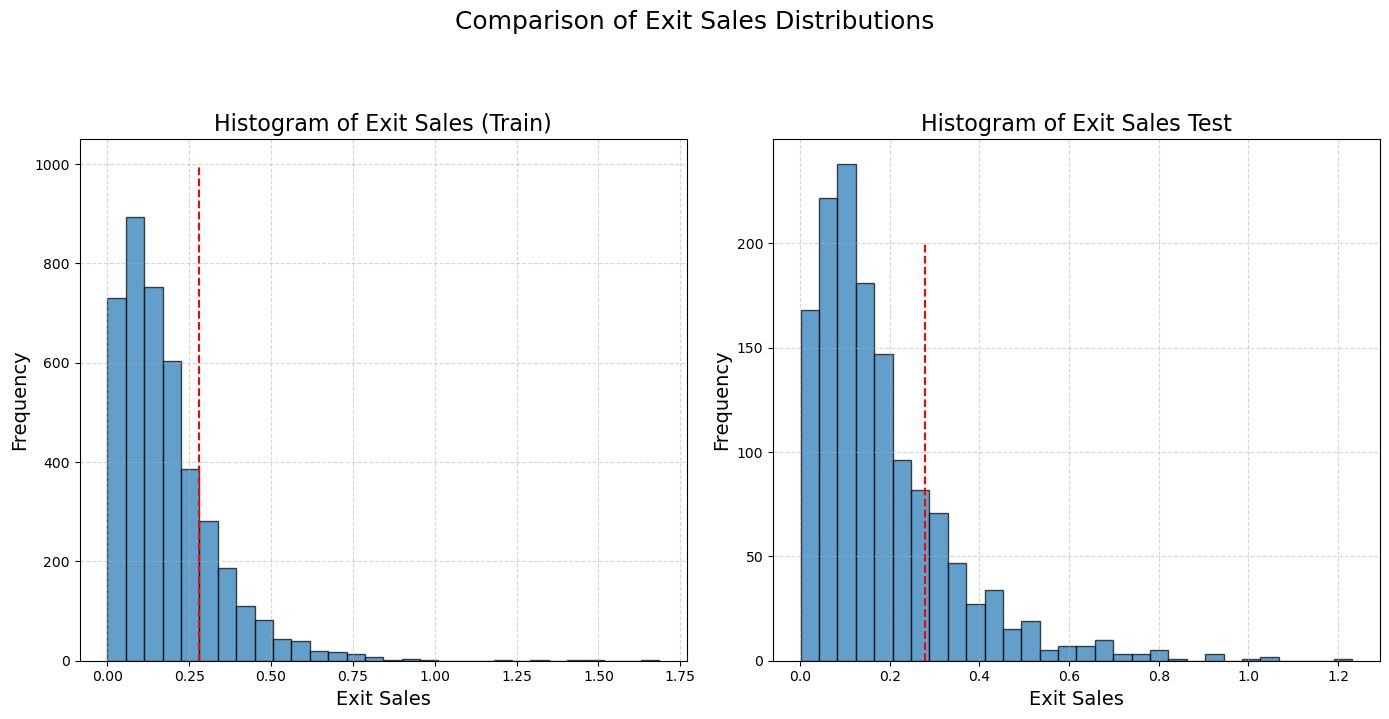

In [28]:
# Create subplots side by side without shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=False)

# Plot histogram for Exit Sales (Training Data)
axes[0].hist(item_sales_train[:, 0:4].sum(axis=1), bins=30, alpha=0.7, edgecolor='black')
axes[0].vlines(treshold, 0, 1000, color='red', linestyle='--', label='80th Percentile')
axes[0].set_title('Histogram of Exit Sales (Train)', fontsize=16)
axes[0].set_xlabel('Exit Sales', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot histogram for Exit Sales Test
axes[1].hist(item_sales_test[:, 0:4].sum(axis=1), bins=30, alpha=0.7, edgecolor='black')
axes[1].vlines(treshold, 0, 200, color='red', linestyle='--', label='80th Percentile')
axes[1].set_title('Histogram of Exit Sales Test', fontsize=16)
axes[1].set_xlabel('Exit Sales', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Add a main title
fig.suptitle('Comparison of Exit Sales Distributions', fontsize=18, y=1.02)

# Adjust layout to accommodate the main title
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

Binary classification

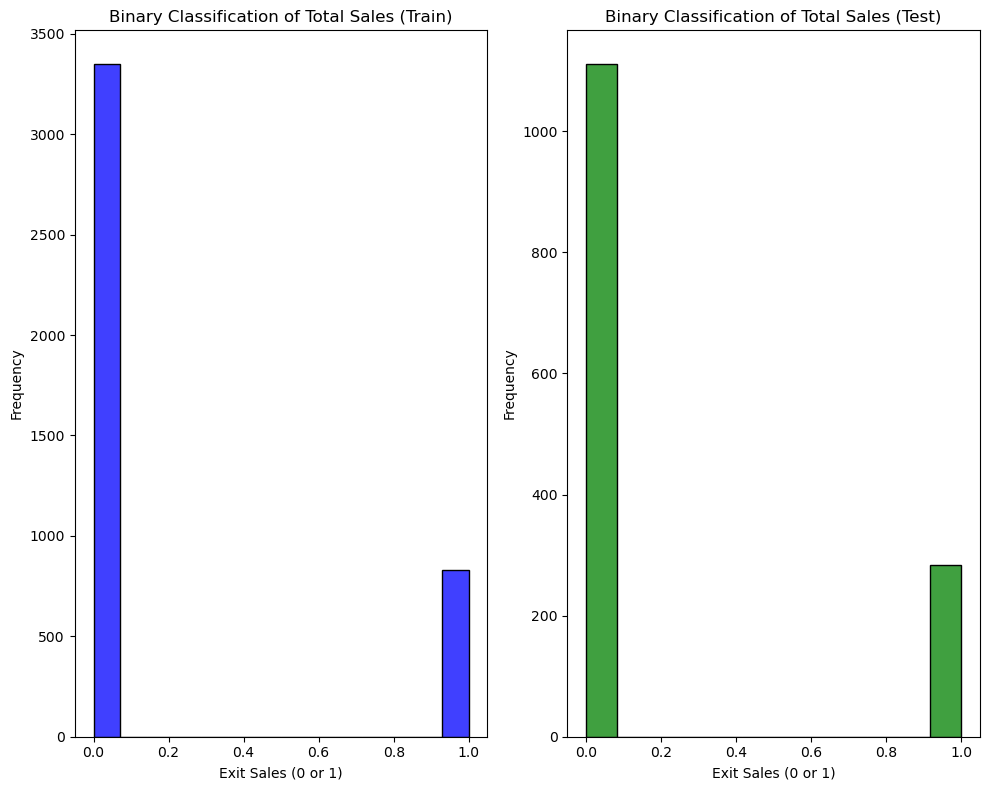

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plot binary classification for training data
sns.histplot(exit_sales, kde=False, color='blue', ax=axes[0])
axes[0].set_title("Binary Classification of Total Sales (Train)")
axes[0].set_xlabel("Exit Sales (0 or 1)")
axes[0].set_ylabel("Frequency")

# Plot binary classification for test data
sns.histplot(exit_sales_test, kde=False, color='green', ax=axes[1])
axes[1].set_title("Binary Classification of Total Sales (Test)")
axes[1].set_xlabel("Exit Sales (0 or 1)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Category histogram

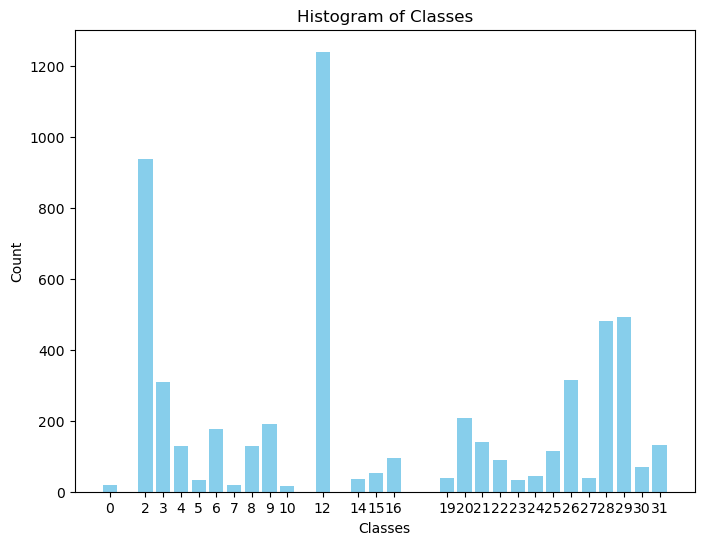

In [33]:
unique_classes, counts = np.unique(categories_combined, return_counts=True)

# Create the histogram
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Histogram of Classes')
plt.xticks(unique_classes)  # Ensure all classes are shown on the x-axis
plt.show()

Seasons

Sales trend

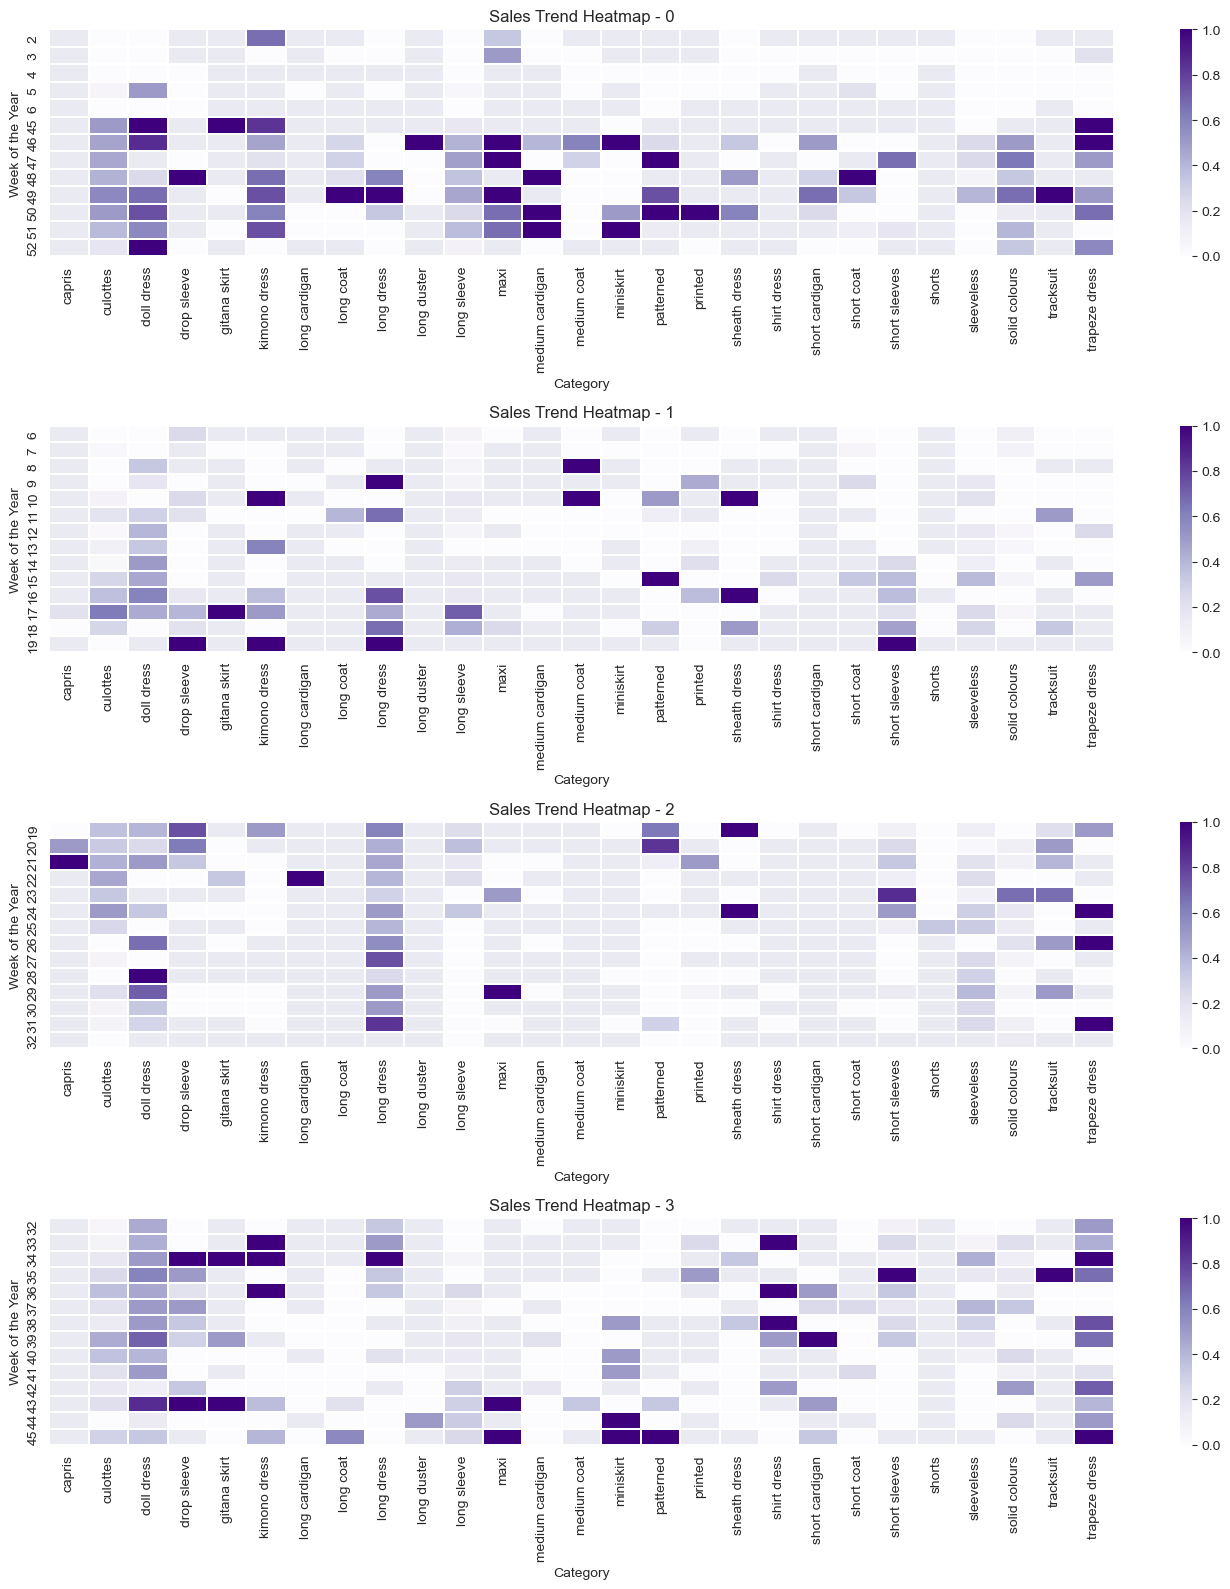

In [36]:
# Convert Week, Month, and Year to proper integers
sales_trend_df = pd.DataFrame({
    "Week": (temporal_features_engineered_combined[:, 0]),  # Week of the year
    "Month": (temporal_features_engineered_combined[:, 1]),  # Month of the year
    "Year": (temporal_features_engineered_combined[:, 2]),  # Year
    # "Total Sales": total_sales,
    "Total Sales": (item_sales_combined[:, 0:4].sum(axis=1) >= treshold).astype(int),
    "Category": categories_combined
})

sns.set_style("dark")  # Options: "whitegrid", "darkgrid", "dark", "white", "ticks"

reversed_cat_dict = {v: k for k, v in cat_dict.items()}

# Apply the classification to create a new Season column
sales_trend_df["Category"] = sales_trend_df["Category"].map(reversed_cat_dict)
all_categories = sorted(sales_trend_df["Category"].unique())

sales_trend_df["Season"] = temporal_features_engineered_combined[:, 5]

# Calculate the global min and max for the color scale
global_min = sales_trend_df["Total Sales"].min()
global_max = sales_trend_df["Total Sales"].max()

# Plot the heatmap for each season with different colormaps
plt.figure(figsize=(14, 16))
for i, season in enumerate([0,1,2,3]):#["Winter", "Spring", "Summer", "Autumn"]):
    season_data = sales_trend_df[sales_trend_df["Season"] == season]
    season_pivot = season_data.pivot_table(values="Total Sales", index="Week", columns="Category", aggfunc='mean').reindex(columns=all_categories)

    # Plot the heatmap for the current season with a consistent color scale
    plt.subplot(4, 1, i + 1)
    sns.heatmap(season_pivot, cmap="Blues" if season == "Winter" else 
                                      "Greens" if season == "Spring" else 
                                      "Oranges" if season == "Summer" else 
                                      "Purples",
                vmin=global_min, vmax=global_max,
                linewidths=0.1)
    
    plt.title(f"Sales Trend Heatmap - {season}")
    plt.xlabel("Category")
    plt.ylabel("Week of the Year")

plt.tight_layout()
plt.show()

/tmp/ipykernel_9180/2055181218.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


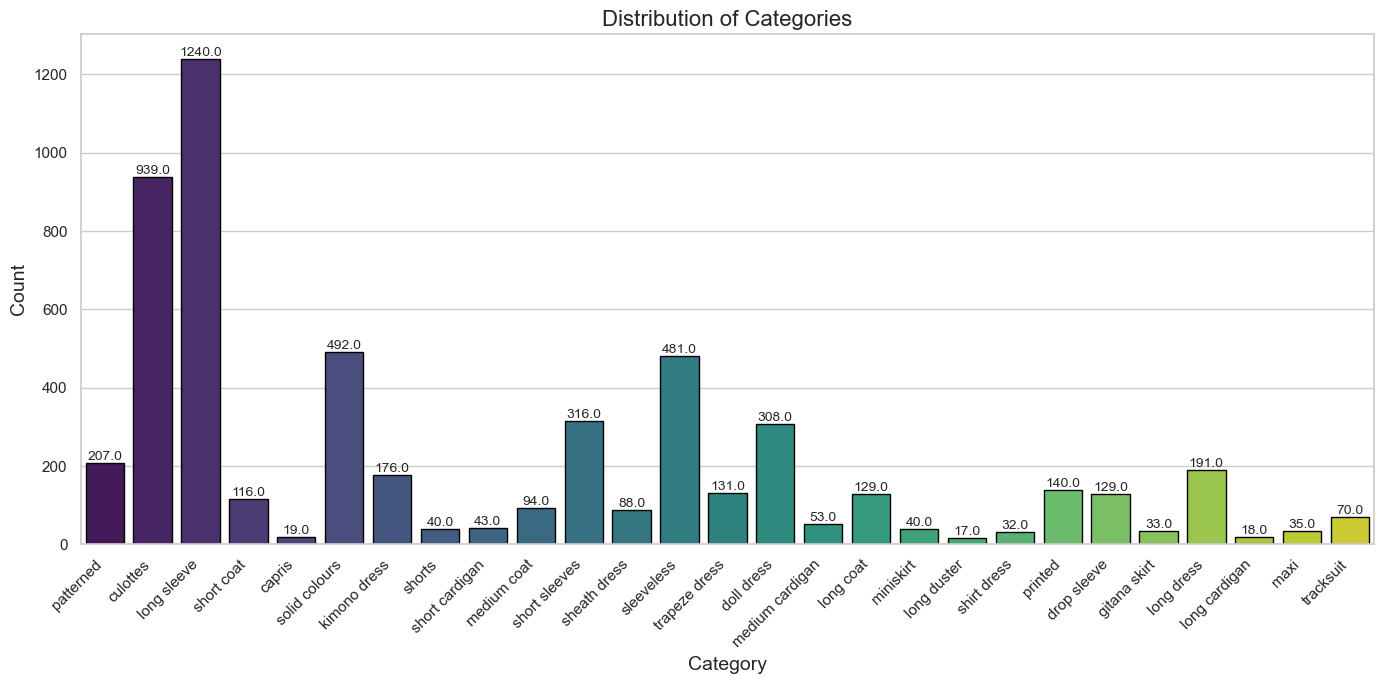

In [45]:
# Set the visual style
sns.set(style="whitegrid")

# Create a figure with a larger size for better readability
plt.figure(figsize=(14, 7))

reversed_cat_dict = {v: k for k, v in cat_dict.items()}
plot_data = pd.DataFrame({'Category': categories_combined})
plot_data['Category'] = plot_data['Category'].map(reversed_cat_dict)

# Plot the distribution of categories using a countplot
sns.countplot(
    data=plot_data,
    x='Category',
    palette='viridis',
    edgecolor='black'
)

# Set plot titles and labels
plt.title('Distribution of Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels if there are many categories for better readability
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height}',
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=10)

# Adjust layout for tightness
plt.tight_layout()

# Display the plot
plt.show()

/tmp/ipykernel_9180/2842085329.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


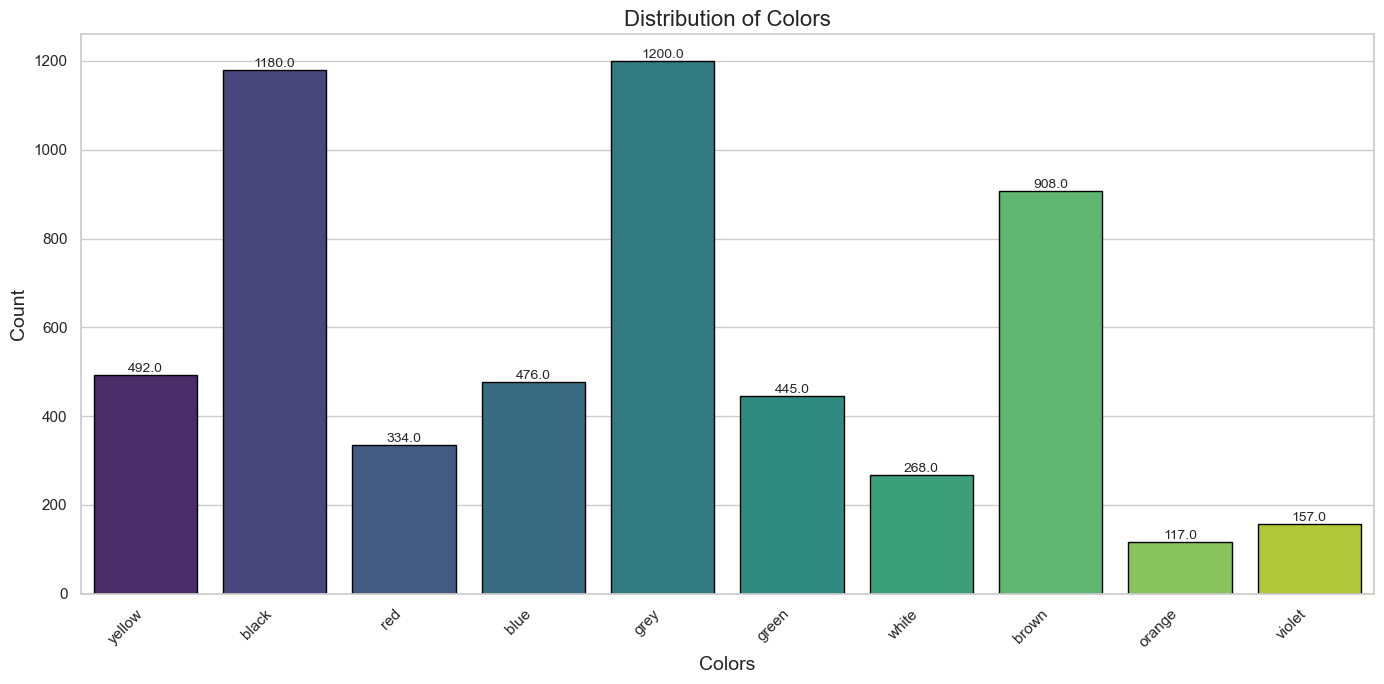

In [47]:
# Set the visual style
sns.set(style="whitegrid")

# Create a figure with a larger size for better readability
plt.figure(figsize=(14, 7))

reversed_col_dict = {v: k for k, v in col_dict.items()}
plot_data = pd.DataFrame({'Category': colors_combined})
plot_data['Category'] = plot_data['Category'].map(reversed_col_dict)

# Plot the distribution of categories using a countplot
sns.countplot(
    data=plot_data,
    x='Category',
    palette='viridis',
    edgecolor='black'
)

# Set plot titles and labels
plt.title('Distribution of Colors', fontsize=16)
plt.xlabel('Colors', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels if there are many categories for better readability
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height}',
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=10)

# Adjust layout for tightness
plt.tight_layout()

# Display the plot
plt.show()

/tmp/ipykernel_9180/843573980.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


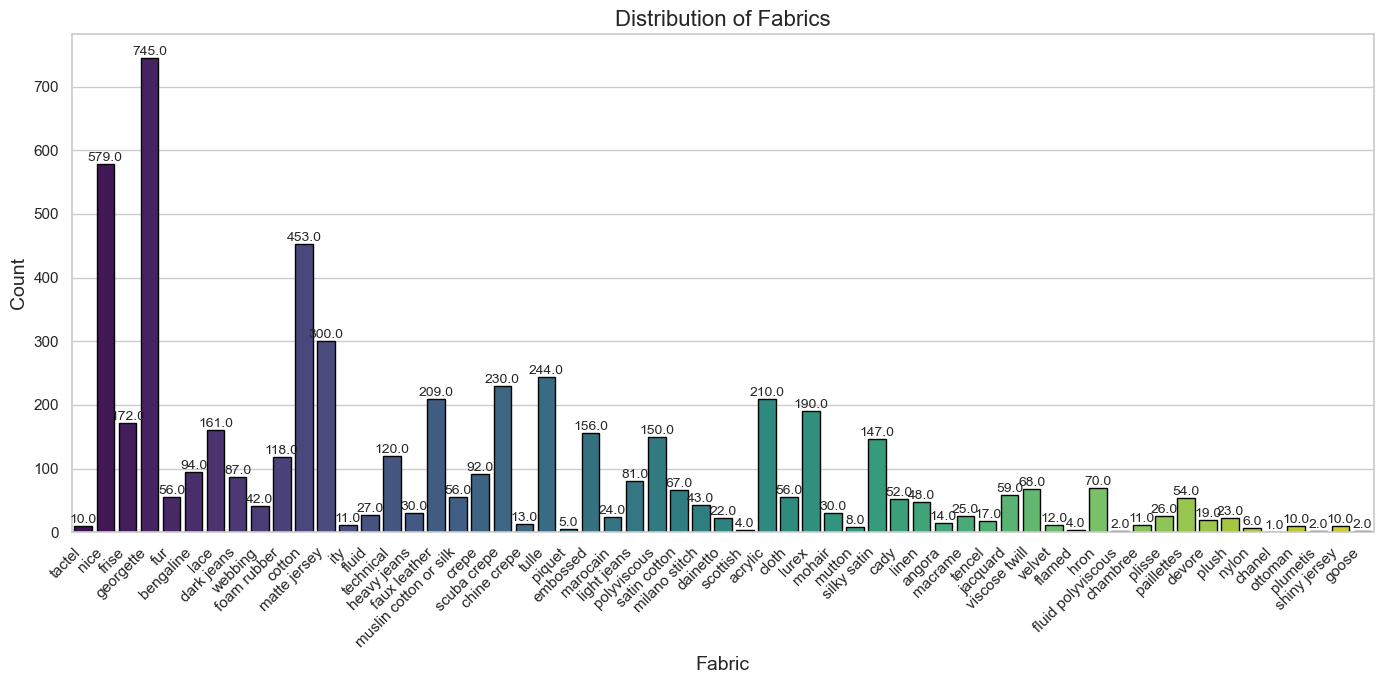

In [51]:
# Set the visual style
sns.set(style="whitegrid")

# Create a figure with a larger size for better readability
plt.figure(figsize=(14, 7))

# Plot the distribution of categories using a countplot
reversed_fav_dict = {v: k for k, v in fab_dict.items()}
plot_data = pd.DataFrame({'Category': fabrics_combined})
plot_data['Category'] = plot_data['Category'].map(reversed_fav_dict)

# Plot the distribution of categories using a countplot
sns.countplot(
    data=plot_data,
    x='Category',
    palette='viridis',
    edgecolor='black'
)

# Set plot titles and labels
plt.title('Distribution of Fabrics', fontsize=16)
plt.xlabel('Fabric', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels if there are many categories for better readability
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height}',
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=10)

# Adjust layout for tightness
plt.tight_layout()

# Display the plot
plt.show()

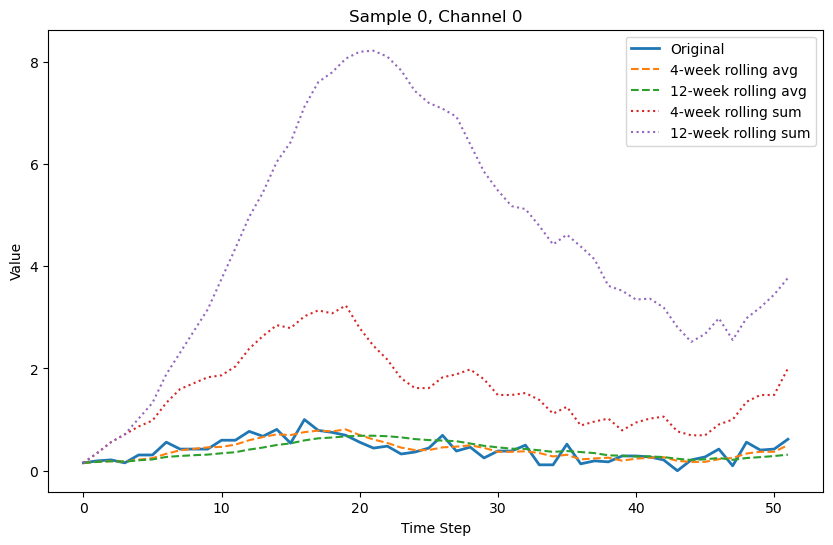

In [23]:
# Choose a sample and a trend channel to visualize
sample_idx = 0
channel_idx = 0

# Extract the series for that sample and channel
gtrend_series = pd.Series(gtrends[sample_idx, channel_idx, :])

# Compute rolling values for the entire time series, not just the last value
rolling_avg_4w_series = gtrend_series.rolling(window=4, min_periods=1).mean()
rolling_avg_12w_series = gtrend_series.rolling(window=12, min_periods=1).mean()
rolling_sum_4w_series = gtrend_series.rolling(window=4, min_periods=1).sum()
rolling_sum_12w_series = gtrend_series.rolling(window=12, min_periods=1).sum()

# Plot them all on one figure
plt.figure(figsize=(10, 6))
plt.plot(gtrend_series, label='Original', linewidth=2)
plt.plot(rolling_avg_4w_series, label='4-week rolling avg', linestyle='--')
plt.plot(rolling_avg_12w_series, label='12-week rolling avg', linestyle='--')
plt.plot(rolling_sum_4w_series, label='4-week rolling sum', linestyle=':')
plt.plot(rolling_sum_12w_series, label='12-week rolling sum', linestyle=':')

plt.title(f"Sample {sample_idx}, Channel {channel_idx}")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()


Umap Plots

In [29]:
umap_model = umap.UMAP(
    n_neighbors=15,    # Balances local and global structure
    min_dist=0.1,      # Controls the tightness of the embedding
    metric='euclidean',# Distance metric
    random_state=42    # For reproducibility
)

# Fit UMAP on the training data and transform
embedding_train = umap_model.fit_transform(X_train_orig)

# Transform the test data using the same UMAP model
embedding_test = umap_model.transform(X_test_orig)

/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [1]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Training data scatter plot
scatter_train = axes[0].scatter(
    embedding_train[:, 0], embedding_train[:, 1], c=item_sales_train.sum(axis=1),
    cmap='viridis', s=50, alpha=0.7
)
axes[0].set_title('UMAP Projection of Training Data')
axes[0].set_xlabel('UMAP1')
axes[0].set_ylabel('UMAP2')
plt.colorbar(scatter_train, ax=axes[0], label='Total Sales (Train)', orientation='vertical')

# Test data scatter plot
scatter_test = axes[1].scatter(
    embedding_test[:, 0], embedding_test[:, 1], c
    cmap='viridis', s=50, alpha=0.7
)
axes[1].set_title('UMAP Projection of Test Data')
axes[1].set_xlabel('UMAP1')
plt.colorbar(scatter_test, ax=axes[1], label='Total Sales (Test)', orientation='vertical')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [30]:
umap_model = umap.UMAP(
    n_neighbors=15,    # Balances local and global structure
    min_dist=0.1,      # Controls the tightness of the embedding
    metric='euclidean',# Distance metric
    random_state=42    # For reproducibility
)

# Fit UMAP on the training data and transform
embedding_train_final = umap_model.fit_transform(X_train)

# Transform the test data using the same UMAP model
embedding_test_final = umap_model.transform(X_test)

/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


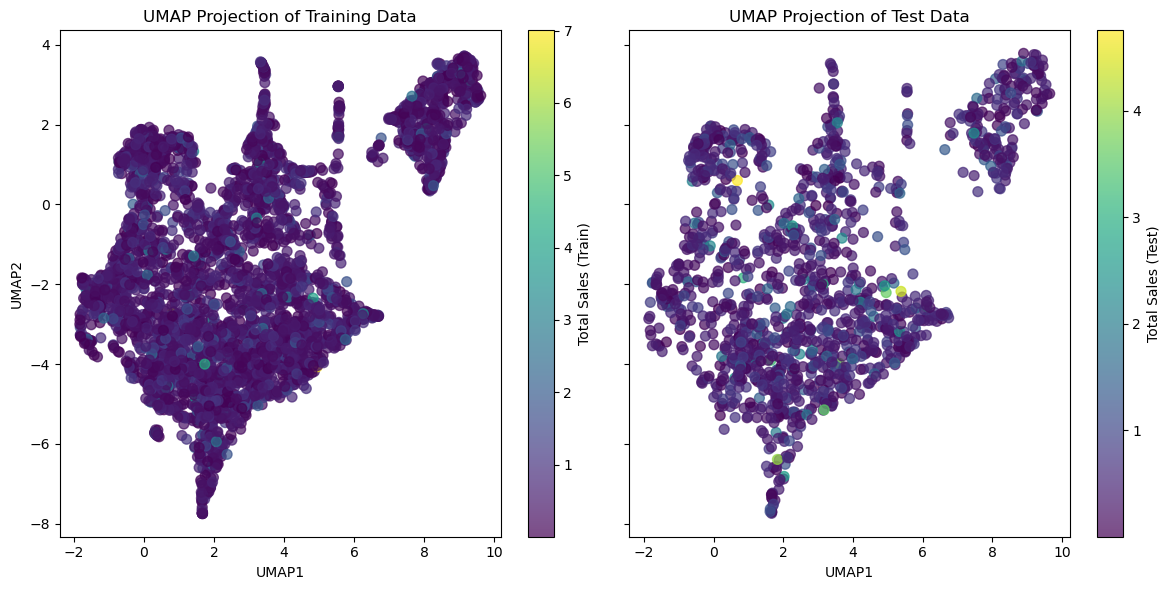

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Training data scatter plot
scatter_train = axes[0].scatter(
    embedding_train_final[:, 0], embedding_train_final[:, 1], c=item_sales_train.sum(axis=1),
    cmap='viridis', s=50, alpha=0.7
)
axes[0].set_title('UMAP Projection of Training Data')
axes[0].set_xlabel('UMAP1')
axes[0].set_ylabel('UMAP2')
plt.colorbar(scatter_train, ax=axes[0], label='Total Sales (Train)', orientation='vertical')

# Test data scatter plot
scatter_test = axes[1].scatter(
    embedding_test_final[:, 0], embedding_test_final[:, 1], c=item_sales_test.sum(axis=1),
    cmap='viridis', s=50, alpha=0.7
)
axes[1].set_title('UMAP Projection of Test Data')
axes[1].set_xlabel('UMAP1')
plt.colorbar(scatter_test, ax=axes[1], label='Total Sales (Test)', orientation='vertical')

plt.tight_layout()
plt.show()

### Bag of Words

In [30]:
# sift = cv2.SIFT_create()

# descriptors_list_dense = []
# for image in tqdm(images):
#     descriptors = extact_sift_features_dense(image)
    
#     if descriptors is not None:
#         descriptors_list_dense.append(descriptors)
#     else:
#         descriptors_list_dense.append(np.zeros((1, 128)))

In [31]:
# with open('descriptors_list_dense_2.pkl', 'wb') as file:
#     pickle.dump(descriptors_list_dense, file)

In [32]:
# # Stack all descriptors together
# all_descriptors = np.vstack(descriptors_list_dense)
# print(all_descriptors.shape)
# # Use K-means to create a visual vocabulary
# k = 200  # Number of visual words
# kmeans = KMeans(n_clusters=k)
# kmeans.fit(all_descriptors)

# # Save the cluster centers as the visual vocabulary
# visual_words = kmeans.cluster_centers_

In [33]:
# # Save descriptors_list_dense to a file
# with open('descriptors_list_dense_2.pkl', 'wb') as file:
#     pickle.dump(descriptors_list_dense, file)
# np.save('visual_words_2.npy', visual_words)
# # Save the KMeans model
# with open('kmeans_model_2.pkl', 'wb') as file:
#     pickle.dump(kmeans, file)

##### Season filtering

In [33]:
def get_season_data(season_code, 
                   temporal_features_train, temporal_features_test,
                   categories_train, categories_test,
                   colors_train, colors_test,
                   fabrics_train, fabrics_test,
                   temporal_features_train_full, temporal_features_test_full,
                   gtrends_train, gtrends_test,
                   images_train, images_test,
                   embeddings_train, embeddings_test,
                   visual_words_train, visual_words_test,
                   item_sales_train, item_sales_test):


    
    # Find indices for the specified season in training data
    
    season_train_indices = np.where(temporal_features_train[:, 5] == season_code)[0]
    
    # Filter training datasets
    filtered_categories_train = categories_train[season_train_indices]
    filtered_colors_train = colors_train[season_train_indices]
    filtered_fabrics_train = fabrics_train[season_train_indices]
    filtered_temporal_train = temporal_features_train_full[season_train_indices]
    filtered_gtrends_train = gtrends_train[season_train_indices]
    filtered_images_train = images_train[season_train_indices]
    filtered_embeddings_train = embeddings_train[season_train_indices]
    filtered_visual_words_train = visual_words_train[season_train_indices]
    filtered_item_sales_train = item_sales_train[season_train_indices]
    
    # Find indices for the specified season in testing data
    season_test_indices = np.where(temporal_features_test[:, 5] == season_code)[0]
    
    # Filter testing datasets
    filtered_categories_test = categories_test[season_test_indices]
    filtered_colors_test = colors_test[season_test_indices]
    filtered_fabrics_test = fabrics_test[season_test_indices]
    filtered_temporal_test = temporal_features_test_full[season_test_indices]
    filtered_gtrends_test = gtrends_test[season_test_indices]
    filtered_images_test = images_test[season_test_indices]
    filtered_embeddings_test = embeddings_test[season_test_indices]
    filtered_visual_words_test = visual_words_test[season_test_indices]
    filtered_item_sales_test = item_sales_test[season_test_indices]
    
    return {
        'train': {
            'categories': filtered_categories_train,
            'colors': filtered_colors_train,
            'fabrics': filtered_fabrics_train,
            'temporal_features': filtered_temporal_train,
            'gtrends': filtered_gtrends_train,
            'images': filtered_images_train,
            'embeddings': filtered_embeddings_train,
            'visual_words': filtered_visual_words_train,
            'item_sales': filtered_item_sales_train
        },
        'test': {
            'categories': filtered_categories_test,
            'colors': filtered_colors_test,
            'fabrics': filtered_fabrics_test,
            'temporal_features': filtered_temporal_test,
            'gtrends': filtered_gtrends_test,
            'images': filtered_images_test,
            'embeddings': filtered_embeddings_test,
            'visual_words': filtered_visual_words_test,
            'item_sales': filtered_item_sales_test
        }
    }

#### Specific Category

In [34]:
from collections import Counter


def fit_model_by_category(specific_category, metrics_collection, data, percentile=80, global_treshold=True):
    local_categories_train = data['train']['categories']
    local_colors_train = data['train']['colors']
    local_fabrics_train = data['train']['fabrics']
    local_temporal_features_train = data['train']['temporal_features']
    local_gtrends_train = data['train']['gtrends']
    local_images_train = data['train']['images']
    local_embeddings_train = data['train']['embeddings']
    local_visual_words_train = data['train']['visual_words']
    local_item_sales_train = data['train']['item_sales']
    
    local_categories_test = data['test']['categories']
    local_colors_test = data['test']['colors']
    local_fabrics_test = data['test']['fabrics']
    local_temporal_features_test = data['test']['temporal_features']
    local_gtrends_test = data['test']['gtrends']
    local_images_test = data['test']['images']
    local_embeddings_test = data['test']['embeddings']
    local_visual_words_test = data['test']['visual_words']
    local_item_sales_test = data['test']['item_sales']
    
    theoretical_metrics = {
            'T_Precision_0':None,
            'T_Recall_0':None,
            'T_F1-Score_0':None,
            'T_Support_0':None,
            'T_Precision_1':None,
            'T_Recall_1':None,
            'T_F1-Score_1':None,
            'T_Support_1':None,
        }
    
    # Select the specific category indices
    specific_category_indices = np.where(local_categories_train == specific_category)[0] 
    specific_category_indices_test = np.where(local_categories_test == specific_category)[0]
    
    category_sales = local_item_sales_train[specific_category_indices, 0:4].sum(axis=1)
    
    # Compute the percentile threshold
    if len(category_sales) != 0:
        if global_treshold:
            threshold = np.percentile(item_sales_combined[:, 0:4].sum(axis=1), percentile)
        else:
            threshold = np.percentile(category_sales, percentile) # TRESHOLD PROBLEM SINCE NOT ABLE TO CAPUTRE THE POSITIVE SALES OF EACH PARTITION
        
        # SALES ON THE FIRST MONTH
        y_category = (local_item_sales_train[:, 0:4].sum(axis=1) >= threshold).astype(int)[specific_category_indices]
        y_category_test = (local_item_sales_test[:, 0:4].sum(axis=1) >= threshold).astype(int)[specific_category_indices_test]
            
        X_category = np.column_stack([
            # np.ones(len(specific_category_indices)),
            # local_embeddings_train[specific_category_indices],
            local_visual_words_train[specific_category_indices],
            local_temporal_features_train[specific_category_indices],
            local_gtrends_train[specific_category_indices],
            # local_colors_train[specific_category_indices],
            # local_categories_train[specific_category_indices],
            # local_fabrics_train[specific_category_indices],
        ])
        X_category_test = np.column_stack([
            # np.ones(len(specific_category_indices_test)),
            # local_embeddings_test[specific_category_indices_test],
            local_visual_words_test[specific_category_indices_test],
            local_temporal_features_test[specific_category_indices_test],
            local_gtrends_test[specific_category_indices_test],
            # local_colors_test[specific_category_indices_test],
            # local_categories_test[specific_category_indices_test],
            # local_fabrics_test[specific_category_indices_test],
            
        ])
    else:
        print(f"Category '{specific_category}' skipped: No sales data available.")
        metrics_collection.append({
            'Category': specific_category,
            'Status': 'Skipped - No Sales Data',
            # Metrics for class 0
            'Precision_0': None,
            'Recall_0': None,
            'F1-Score_0': None,
            'Support_0': None,
            # Metrics for class 1
            'Precision_1': None,
            'Recall_1': None,
            'F1-Score_1': None,
            'Support_1': None,
            'Confusion_Matrix': None,
            **theoretical_metrics
        })
        return
    
    # Check if both classes are present in the training data
    train_class_counts = Counter(y_category)
    if len(train_class_counts) < 2:
        print(f"Category '{specific_category}' skipped: Only one class present in training data ({train_class_counts}).")
        
        # Add theoretical classes:
        single_class = list(train_class_counts.keys())[0]
        
        theoretical_metrics = {
            'T_Precision_0': 1.0 if single_class == 0 else None,
            'T_Recall_0': 1.0 if single_class == 0 else None,
            'T_F1-Score_0': 1.0 if single_class == 0 else None,
            'T_Support_0': train_class_counts[0] if single_class == 0 else None,
            'T_Precision_1': 1.0 if single_class == 1 else None,
            'T_Recall_1': 1.0 if single_class == 1 else None,
            'T_F1-Score_1': 1.0 if single_class == 1 else None,
            'T_Support_1': train_class_counts[1] if single_class == 1 else None,
            'T_Confusion_Matrix': [[train_class_counts[0] if single_class == 0 else 0],
                                            [0 if single_class == 0 else train_class_counts[1]]],
        }
        
        metrics_collection.append({
            'Category': specific_category,
            'Status': 'Skipped - Single Class in Training',
            # Metrics for class 0
            'Precision_0': None,
            'Recall_0': None,
            'F1-Score_0': None,
            'Support_0': None,
            # Metrics for class 1
            'Precision_1': None,
            'Recall_1': None,
            'F1-Score_1': None,
            'Support_1': None,
            'Confusion_Matrix': None,
            **theoretical_metrics
        })
        return
    
    # Check if both classes are present in the test data
    test_class_counts = Counter(y_category_test)
    if len(test_class_counts) < 2:
        print(f"Category '{specific_category}' warning: Only one class present in test data ({test_class_counts}). Evaluation metrics may be limited.")
    
    
    # Resample the training data to address class imbalance
    try:
        rus = RandomUnderSampler(random_state=42)
        X_category_resampled, y_category_resampled = rus.fit_resample(X_category, y_category)
    except ValueError as e:
        print(f"Resampling failed for category '{specific_category}': {e}")
        metrics_collection.append({
            'Category': specific_category,
            'Status': f'Resampling Failed: {e}',
            # Metrics for class 0
            'Precision_0': None,
            'Recall_0': None,
            'F1-Score_0': None,
            'Support_0': None,
            # Metrics for class 1
            'Precision_1': None,
            'Recall_1': None,
            'F1-Score_1': None,
            'Support_1': None,
            'Confusion_Matrix': None,
            **theoretical_metrics
        })
        return
    
    # Initialize and train the classifier
    model = XGBClassifier(n_estimators=1500, random_state=33, eval_metric='logloss')
    params = {
        'objective': 'binary',        # Binary classification
        'metric': 'binary_error',     # Metric for evaluation
        'boosting_type': 'gbdt',      # Gradient Boosting Decision Tree
        'num_leaves': 31,             # Number of leaves in one tree
        'learning_rate': 0.05,        # Learning rate
        'feature_fraction': 0.9,      # Fraction of features to consider in each iteration
        'bagging_fraction': 0.8,      # Fraction of data to use in each iteration
        'bagging_freq': 5,            # Frequency of bagging
        'random_state': 33,
        'verbosity': 0,
    }
    # model = LGBMClassifier(**params)

    try:
        # model.fit(X_category_resampled, y_category_resampled)
        model.fit(X_category, y_category)
    except ValueError as e:
        print(f"Model training failed for category '{specific_category}': {e}")
        metrics_collection.append({
            'Category': specific_category,
            'Status': f'Training Failed: {e}',
            # Metrics for class 0
            'Precision_0': None,
            'Recall_0': None,
            'F1-Score_0': None,
            'Support_0': None,
            # Metrics for class 1
            'Precision_1': None,
            'Recall_1': None,
            'F1-Score_1': None,
            'Support_1': None,
            'Confusion_Matrix': None,
            **theoretical_metrics
        })
        return
    
    # Make predictions on the test set
    y_pred = model.predict(X_category_test)
    
    # Generate classification report and confusion matrix
    report = classification_report(y_category_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_category_test, y_pred).tolist()  # Convert to list for JSON-serializable format
    
    # Extract metrics for both classes
    # Assuming '0' and '1' are the only classes
    metrics = {}
    for cls in ['0', '1']:
        cls_metrics = report.get(cls, {})
        metrics[f'Precision_{cls}'] = cls_metrics.get('precision', None)
        metrics[f'Recall_{cls}'] = cls_metrics.get('recall', None)
        metrics[f'F1-Score_{cls}'] = cls_metrics.get('f1-score', None)
        metrics[f'Support_{cls}'] = cls_metrics.get('support', None)
    
    # Append metrics to the collection
    metrics_collection.append({
        'Category': specific_category,
        'Status': 'Evaluated',
        # Weighted average metrics
         # Weighted average metrics
        'Weighted_Precision': report['weighted avg'].get('precision', None),
        'Weighted_Recall': report['weighted avg'].get('recall', None),
        'Weighted_F1-Score': report['weighted avg'].get('f1-score', None),
        'Weighted_Support': report['weighted avg'].get('support', None),
            'Precision_0': metrics['Precision_0'],
        'Recall_0': metrics['Recall_0'],
        'F1-Score_0': metrics['F1-Score_0'],
        'Support_0': metrics['Support_0'],
        'Precision_1': metrics['Precision_1'],
        'Recall_1': metrics['Recall_1'],
        'F1-Score_1': metrics['F1-Score_1'],
        'Support_1': metrics['Support_1'],
        'Confusion_Matrix': cm
    })
    
    # Optionally, print the metrics for each category
    # print(f"\nCategory: '{specific_category}'")
    # print("Classification Report:")
    # print(classification_report(y_category_test, y_pred, zero_division=0))
    # print("Confusion Matrix:")
    # print(confusion_matrix(y_category_test, y_pred))

In [37]:
metrics_collection = dict()
for season in range(4):
    print(f"  Season: {season}")
    metrics_collection[season] = []
        
    for category_idx in range(len(cat_dict)):
        category_name = reversed_cat_dict[category_idx]
        # print(f"Category: {category_name}")
    
    # Iterate over each season within the current category
    
    
        season_data = get_season_data(
            season_code=season,
            temporal_features_train=temporal_features_train,
            temporal_features_test=temporal_features_test,
            categories_train=categories_train,
            categories_test=categories_test,
            colors_train=colors_train,
            colors_test=colors_test,
            fabrics_train=fabrics_train,
            fabrics_test=fabrics_test,
            temporal_features_train_full=temporal_features_train,
            temporal_features_test_full=temporal_features_test,
            gtrends_train=gtrends_train,
            gtrends_test=gtrends_test,
            images_train=images_train,
            images_test=images_test,
            embeddings_train=embeddings_train,
            embeddings_test=embeddings_test,
            visual_words_train=visual_words_train,
            visual_words_test=visual_words_test,
            item_sales_train=item_sales_train,
            item_sales_test=item_sales_test
        )
        fit_model_by_category(category_idx, metrics_collection[season], season_data, percentile=80, global_treshold=True)

  Season: 0
Category '0' skipped: No sales data available.
Category '1' skipped: No sales data available.
Category '4' warning: Only one class present in test data (Counter({0: 4})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '5' skipped: No sales data available.
Category '7' skipped: Only one class present in training data (Counter({0: 3})).
Category '9' warning: Only one class present in test data (Counter({0: 3})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '10' skipped: Only one class present in training data (Counter({0: 2})).
Category '11' skipped: No sales data available.
Category '13' skipped: No sales data available.
Category '14' warning: Only one class present in test data (Counter({1: 1})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '17' skipped: No sales data available.
Category '18' skipped: No sales data available.
Category '21' warning: Only one class present in test data (Counter({0: 4})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '22' warning: Only one class present in test data (Counter({0: 3})). Evaluation metrics may be limited.
Category '23' skipped: Only one class present in training data (Counter({0: 2})).
Category '27' skipped: Only one class present in training data (Counter({0: 1})).
Category '30' warning: Only one class present in test data (Counter()). Evaluation metrics may be limited.
  Season: 1
Category '0' skipped: Only one class present in training data (Counter({0: 7})).
Category '1' skipped: No sales data available.
Category '5' warning: Only one class present in test data (Counter()). Evaluation metrics may be limited.
Category '7' skipped: Only one class present in training data (Counter({0: 2})).
Category '10' skipped: No sales data available.
Category '11' skipped: No sales data available.
Category '13' skipped: No sales data available.
Category '14' warning: Only one class present in test data (Counter({0: 3})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '15' skipped: Only one class present in training data (Counter({0: 3})).
Category '16' warning: Only one class present in test data (Counter({0: 3})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '17' skipped: No sales data available.
Category '18' skipped: No sales data available.
Category '19' skipped: Only one class present in training data (Counter({0: 6})).
Category '23' skipped: Only one class present in training data (Counter({0: 8})).
Category '24' skipped: No sales data available.
Category '27' skipped: Only one class present in training data (Counter({0: 4})).
Category '29' warning: Only one class present in test data (Counter({0: 44})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '31' warning: Only one class present in test data (Counter({0: 6})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


  Season: 2
Category '0' warning: Only one class present in test data (Counter({0: 1})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '1' skipped: No sales data available.
Category '5' warning: Only one class present in test data (Counter({0: 2})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '6' warning: Only one class present in test data (Counter({0: 2})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '7' skipped: No sales data available.
Category '8' skipped: No sales data available.
Category '10' skipped: No sales data available.
Category '11' skipped: No sales data available.
Category '13' skipped: No sales data available.
Category '14' warning: Only one class present in test data (Counter()). Evaluation metrics may be limited.
Category '15' skipped: Only one class present in training data (Counter({0: 4})).
Category '16' skipped: No sales data available.
Category '17' skipped: No sales data available.
Category '18' skipped: No sales data available.
Category '19' skipped: Only one class present in training data (Counter({0: 4})).
Category '21' skipped: Only one class present in training data (Counter({0: 37})).
Category '22' warning: Only one class present in test data (Counter({0: 3})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '23' skipped: Only one class present in training data (Counter({0: 5})).
Category '24' skipped: No sales data available.
Category '25' skipped: Only one class present in training data (Counter({0: 3})).
Category '27' warning: Only one class present in test data (Counter({0: 8})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '31' warning: Only one class present in test data (Counter({0: 1})). Evaluation metrics may be limited.
  Season: 3


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '0' skipped: No sales data available.
Category '1' skipped: No sales data available.
Category '7' skipped: Only one class present in training data (Counter({0: 9})).
Category '8' warning: Only one class present in test data (Counter({0: 13})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '10' skipped: Only one class present in training data (Counter({0: 9})).
Category '11' skipped: No sales data available.
Category '13' skipped: No sales data available.
Category '14' warning: Only one class present in test data (Counter({1: 1})). Evaluation metrics may be limited.
Category '17' skipped: No sales data available.
Category '18' skipped: No sales data available.
Category '20' warning: Only one class present in test data (Counter({0: 7})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '22' warning: Only one class present in test data (Counter({0: 7})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '23' warning: Only one class present in test data (Counter({0: 3})). Evaluation metrics may be limited.
Category '25' warning: Only one class present in test data (Counter({0: 11})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '27' skipped: No sales data available.
Category '30' skipped: Only one class present in training data (Counter({0: 4})).


In [40]:
# Initialize a list to collect all metrics for overall averages
all_seasons_metrics = []

for season in range(4):
    season_metrics = metrics_collection[season]
    print(f"\n#################### Season: {season} ####################")
    # Convert the metrics list to a pandas DataFrame for easier analysis
    metrics_df = pd.DataFrame(season_metrics)

    # Append to the list for overall metrics
    all_seasons_metrics.append(metrics_df)

    # Define metric columns to average for both classes
    metric_columns_class_0 = ['Precision_0', 'Recall_0', 'F1-Score_0']
    metric_columns_class_1 = ['Precision_1', 'Recall_1', 'F1-Score_1']
    metric_columns_weighted = ['Weighted_Precision', 'Weighted_Recall', 'Weighted_F1-Score']
    metric_columns_endtoend_0 = [['Precision_0', 'T_Precision_0'], ['Recall_0', 'T_Recall_0']]
    metric_columns_endtoend_1 = [['Precision_1', 'T_Precision_1'], ['Recall_1', 'T_Recall_1']]

    # Compute average metrics for class 0, excluding 'Support_0'
    average_metrics_class_0 = metrics_df[metric_columns_class_0].dropna().mean()

    # Compute average metrics for class 1, excluding 'Support_1'
    average_metrics_class_1 = metrics_df[metric_columns_class_1].dropna().mean()

    # Compute average weighted metrics
    average_metrics_weighted = metrics_df[metric_columns_weighted].dropna().mean()

    # Compute total support for both classes
    total_support_0 = metrics_df['Support_0'].sum()
    total_support_1 = metrics_df['Support_1'].sum()
    total_support_weighted = metrics_df['Weighted_Support'].sum()

    print("\nAverage Metrics Across Categories for Class 0:")
    print(average_metrics_class_0)

    print("\nAverage Metrics Across Categories for Class 1:")
    print(average_metrics_class_1)
    
    
    print(f"\nTotal Support Across Categories for Class 0: {total_support_0}")
    print(f"Total Support Across Categories for Class 1: {total_support_1}")
    # print("Supports:")
    # print(pd.DataFrame([metrics_df['Support_0'], metrics_df['Support_1']]).transpose())
    

    print("\nAverage Weighted Metrics Across Categories, with Support: {:.2f}".format(total_support_weighted))
    print(average_metrics_weighted)


    print(pd.DataFrame([metrics_df['Precision_0'].round(2), metrics_df['Recall_0'].round(2), metrics_df['F1-Score_0'].round(2), metrics_df['Support_0'].round(0), metrics_df['Precision_1'].round(2), metrics_df['Recall_1'].round(2), metrics_df['F1-Score_1'].round(2), metrics_df['Support_1'].round(0), metrics_df['T_Precision_0'], metrics_df['T_Recall_0'], metrics_df['T_Precision_1'], metrics_df['T_Recall_1']]).transpose())

    average_metrics_class_0 = {
        f'Mean_{group[0]}_and_{group[1]}': metrics_df[group[0]]
            .combine_first(metrics_df[group[1]])
            .mean()
        for group in metric_columns_endtoend_0
    }

    # Compute average metrics for class 1
    average_metrics_class_1 = {
        f'Mean_{group[0]}_and_{group[1]}': metrics_df[group[0]]
            .combine_first(metrics_df[group[1]])
            .mean()
        for group in metric_columns_endtoend_1
    }

    # Combine results
    average_metrics = {
        'Class_0': average_metrics_class_0,
        'Class_1': average_metrics_class_1,
    }

    print("End2End Average Metrics:")

    print("\nClass 0 Metrics:")
    for key, value in average_metrics['Class_0'].items():
        print(f"  {key}: {value:.4f}")

    print("\nClass 1 Metrics:")
    for key, value in average_metrics['Class_1'].items():
        print(f"  {key}: {value:.4f}")
        
    # print(metrics_df['Support_0'], metrics_df['Support_1'])



# Compute overall average metrics across all seasons
print("\n\nOverall Average Metrics Across All Seasons:")

# Concatenate all metrics into a single DataFrame
combined_metrics_df = pd.concat(all_seasons_metrics, ignore_index=True)

# Define metric columns to average for both classes
metric_columns_class_0 = ['Precision_0', 'Recall_0', 'F1-Score_0']
metric_columns_class_1 = ['Precision_1', 'Recall_1', 'F1-Score_1']
metric_columns_weighted = ['Weighted_Precision', 'Weighted_Recall', 'Weighted_F1-Score']

# Compute average metrics for class 0
average_metrics_class_0_overall = combined_metrics_df[metric_columns_class_0].dropna().mean()
print("\nAverage Metrics Across All Seasons for Class 0:")
print(average_metrics_class_0_overall)

# Compute average metrics for class 1
average_metrics_class_1_overall = combined_metrics_df[metric_columns_class_1].dropna().mean()
print("\nAverage Metrics Across All Seasons for Class 1:")
print(average_metrics_class_1_overall)

# Compute average weighted metrics
average_metrics_weighted_overall = combined_metrics_df[metric_columns_weighted].dropna().mean()
print("\nAverage Weighted Metrics Across All Seasons:")
print(average_metrics_weighted_overall)

# Compute total support across all seasons
total_support_0_overall = combined_metrics_df['Support_0'].sum()
total_support_1_overall = combined_metrics_df['Support_1'].sum()
total_support_weighted_overall = combined_metrics_df['Weighted_Support'].sum()

print(f"\nTotal Support Across All Seasons for Class 0: {total_support_0_overall}")
print(f"Total Support Across All Seasons for Class 1: {total_support_1_overall}")

print("\nAverage Weighted Support Across All Seasons: {:.2f}".format(total_support_weighted_overall))


#################### Season: 0 ####################

Average Metrics Across Categories for Class 0:
Precision_0    0.749265
Recall_0       0.920266
F1-Score_0     0.807450
dtype: float64

Average Metrics Across Categories for Class 1:
Precision_1    0.248628
Recall_1       0.181244
F1-Score_1     0.206612
dtype: float64

Total Support Across Categories for Class 0: 202.0
Total Support Across Categories for Class 1: 81.0

Average Weighted Metrics Across Categories, with Support: 283.00
Weighted_Precision    0.681132
Weighted_Recall       0.738966
Weighted_F1-Score     0.695137
dtype: float64
    Precision_0  Recall_0  F1-Score_0  Support_0  Precision_1  Recall_1  \
0           NaN       NaN         NaN        NaN          NaN       NaN   
1           NaN       NaN         NaN        NaN          NaN       NaN   
2          0.84      0.89        0.86       35.0         0.56      0.45   
3          0.25      1.00        0.40        1.0         0.00      0.00   
4          1.00      1.00 

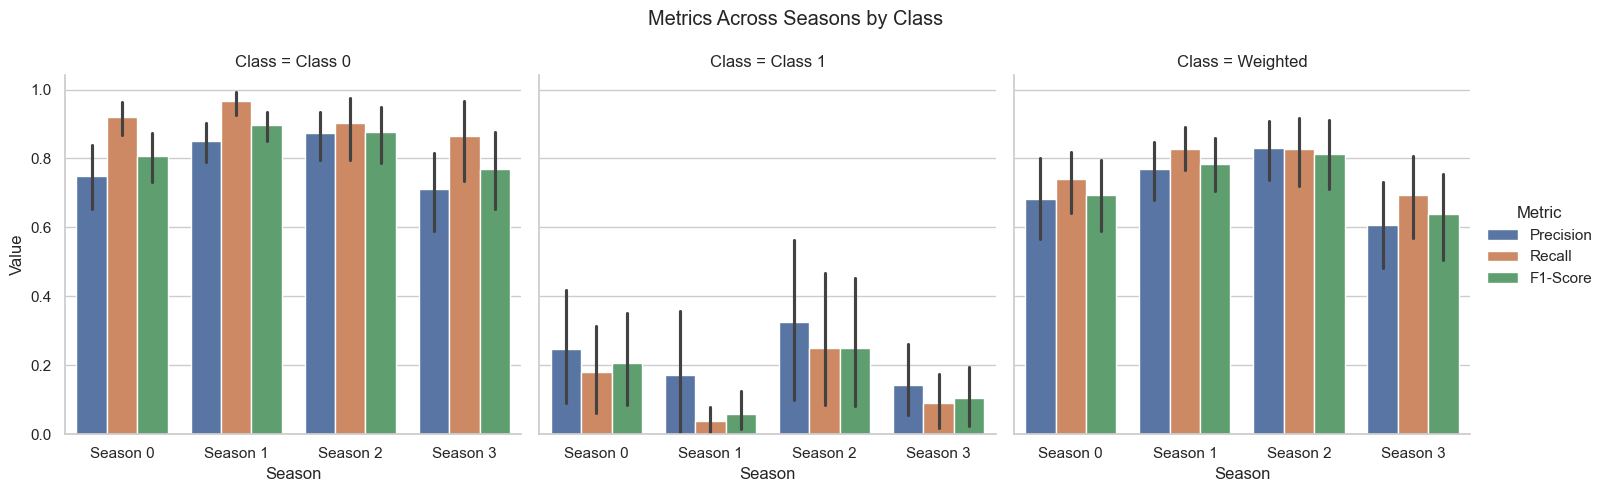

In [39]:
all_seasons_metrics = []
for season in range(4):
    season_metrics = metrics_collection[season]
    metrics_df = pd.DataFrame(season_metrics)
    metrics_df['Season'] = f'Season {season}'
    all_seasons_metrics.append(metrics_df)

combined_metrics_df = pd.concat(all_seasons_metrics, ignore_index=True)

# Melt the DataFrame for plotting
metric_columns = [
    'Precision_0', 'Recall_0', 'F1-Score_0',
    'Precision_1', 'Recall_1', 'F1-Score_1',
    'Weighted_Precision', 'Weighted_Recall', 'Weighted_F1-Score'
]
metrics_melted = combined_metrics_df.melt(
    id_vars=['Season'],
    value_vars=metric_columns,
    var_name='Metric',
    value_name='Value'
)

# Extract Class information
def extract_class(metric):
    if '_0' in metric:
        return 'Class 0'
    elif '_1' in metric:
        return 'Class 1'
    elif 'Weighted' in metric:
        return 'Weighted'
    else:
        return 'Unknown'

metrics_melted['Class'] = metrics_melted['Metric'].apply(extract_class)

# Clean Metric names
metrics_melted['Metric'] = metrics_melted['Metric'].replace({
    'Precision_0': 'Precision',
    'Recall_0': 'Recall',
    'F1-Score_0': 'F1-Score',
    'Precision_1': 'Precision',
    'Recall_1': 'Recall',
    'F1-Score_1': 'F1-Score',
    'Weighted_Precision': 'Precision',
    'Weighted_Recall': 'Recall',
    'Weighted_F1-Score': 'F1-Score'
})

# Plot the metrics
sns.set(style="whitegrid")
g = sns.catplot(
    data=metrics_melted,
    x='Season',
    y='Value',
    hue='Metric',
    col='Class',
    kind='bar',
    height=5,
    aspect=1
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Metrics Across Seasons by Class')
plt.show()

/tmp/ipykernel_15755/1949152996.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_metrics_df = pd.concat(all_metrics, ignore_index=True)


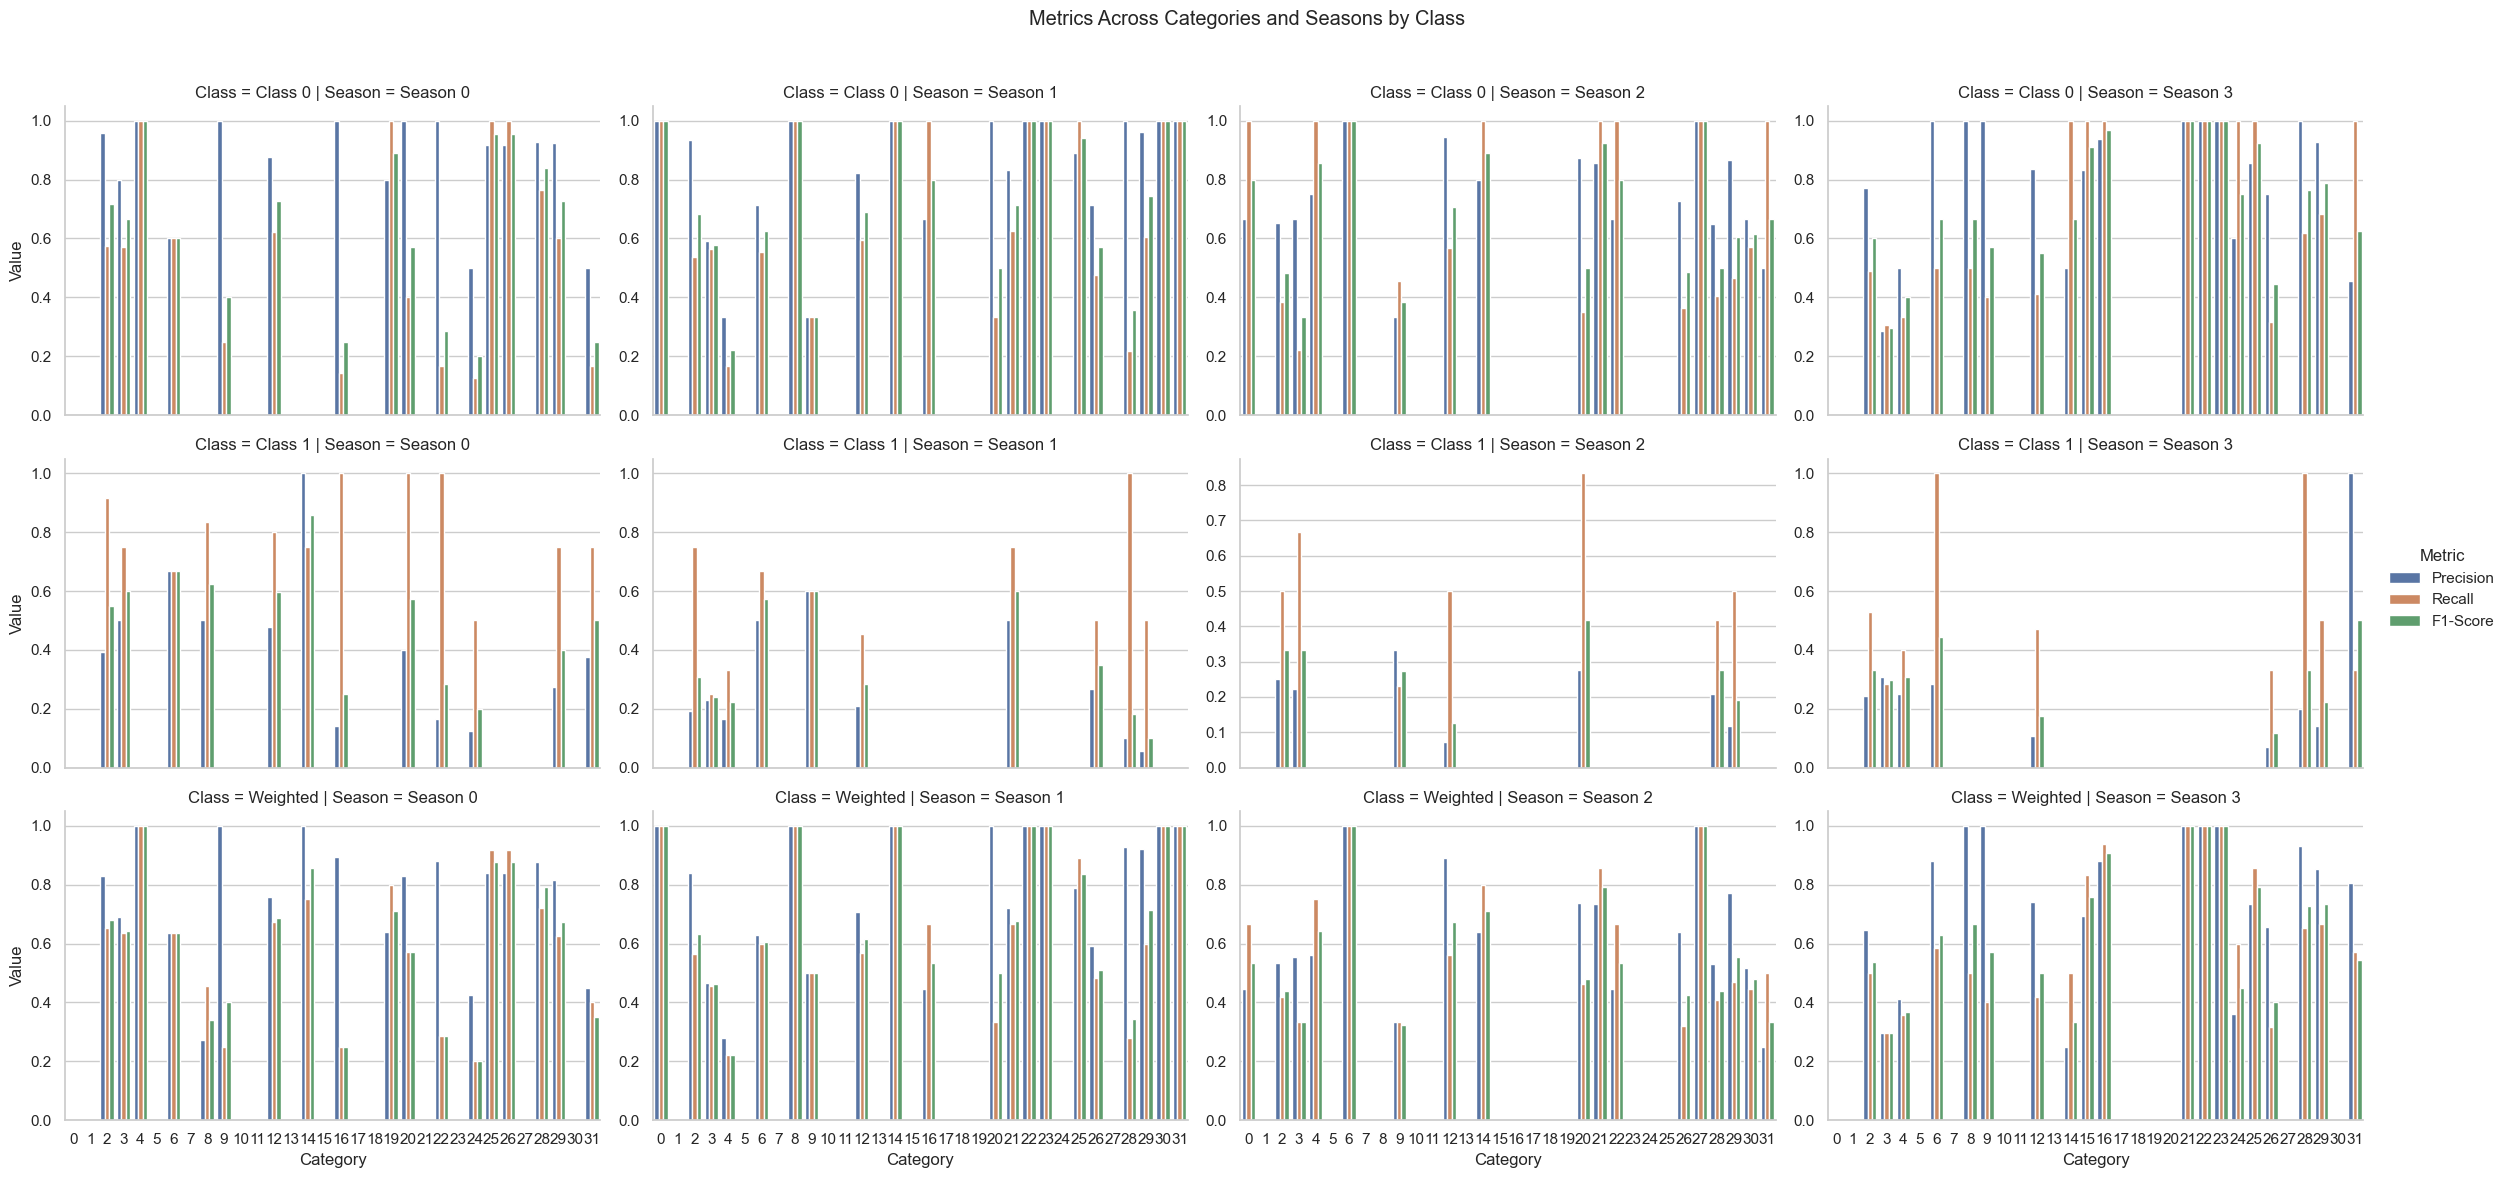

In [117]:
all_metrics = []
for season in metrics_collection:
    for category in range(len(cat_dict)):
        metrics = metrics_collection[season][category]
        metrics_df = pd.DataFrame([metrics])
        metrics_df['Season'] = f'Season {season}'
        metrics_df['Category'] = category
        all_metrics.append(metrics_df)

# Combine all metrics into a single DataFrame
combined_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Melt the DataFrame for plotting
metric_columns = [
    'Precision_0', 'Recall_0', 'F1-Score_0',
    'Precision_1', 'Recall_1', 'F1-Score_1',
    'Weighted_Precision', 'Weighted_Recall', 'Weighted_F1-Score'
]   
metrics_melted = combined_metrics_df.melt(
    id_vars=['Season', 'Category'],
    value_vars=metric_columns,
    var_name='Metric',
    value_name='Value'
)

# Extract Class information
def extract_class(metric):
    if '_0' in metric:
        return 'Class 0'
    elif '_1' in metric:
        return 'Class 1'
    elif 'Weighted' in metric:
        return 'Weighted'
    else:
        return 'Unknown'

metrics_melted['Class'] = metrics_melted['Metric'].apply(extract_class)

# Clean Metric names
metrics_melted['Metric'] = metrics_melted['Metric'].replace({
    'Precision_0': 'Precision',
    'Recall_0': 'Recall',
    'F1-Score_0': 'F1-Score',
    'Precision_1': 'Precision',
    'Recall_1': 'Recall',
    'F1-Score_1': 'F1-Score',
    'Weighted_Precision': 'Precision',
    'Weighted_Recall': 'Recall',
    'Weighted_F1-Score': 'F1-Score'
})

# Plot the metrics
sns.set(style="whitegrid")
g = sns.catplot(
    data=metrics_melted,
    x='Category',
    y='Value',
    hue='Metric',
    col='Season',
    row='Class',
    kind='bar',
    height=4,
    aspect=1.5,
    sharey=False
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Metrics Across Categories and Seasons by Class')

plt.show()

In [ ]:
seasons = metrics_melted['Season'].unique()
classes = ['Class 0', 'Class 1', 'Weighted']

for season in seasons:
    data_subset = metrics_melted[metrics_melted['Season'] == season]
    
    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
    fig.suptitle(f'Metrics in {season}', fontsize=16)
    
    for ax, cls in zip(axes, classes):
        class_data = data_subset[data_subset['Class'] == cls]
        sns.barplot(
            data=class_data,
            x='Category',
            y='Value',
            hue='Metric',
            ax=ax
        )
        ax.set_title(f'{cls} Metrics')
        ax.set_xlabel('Category')
        ax.set_ylabel('Metric Value')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Metric', loc='upper right')
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Adjust to make room for the suptitle
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Define seasons
seasons = ["Spring", "Summer", "Fall", "Winter"]

# Define the number of categories
num_categories = len(cat_dict)

# Define how many categories to display per figure to manage subplot sizes
categories_per_figure = 10  # Adjust this number based on your preference and available screen space

# Calculate the number of figures needed
num_figures = int(np.ceil(num_categories / categories_per_figure))

for fig_num in range(num_figures):
    # Determine the range of categories for the current figure
    start_idx = fig_num * categories_per_figure
    end_idx = min(start_idx + categories_per_figure, num_categories)
    current_categories = range(start_idx, end_idx)
    current_num_categories = end_idx - start_idx

    # Create subplots for the current figure
    fig, axes = plt.subplots(current_num_categories, 4, figsize=(20, 4 * current_num_categories), sharex=True, sharey=True)
    fig.suptitle(f'UMAP Projections by Season and Category with Valid Data (Figure {fig_num + 1}/{num_figures})', fontsize=16)
    
    # If there's only one category in the current figure, axes will not be a 2D array
    if current_num_categories == 1:
        axes = axes.reshape(1, -1)
    
    for ax_row, category_idx in zip(axes, current_categories):
        category_name = reversed_cat_dict[category_idx]
        
        for i, season in enumerate(seasons):
            # Fetch the data for the current season and category
            data = get_season_data(
                season_code=i,
                temporal_features_train=temporal_features_train,
                temporal_features_test=temporal_features_test,
                categories_train=categories_train,
                categories_test=categories_test,
                colors_train=colors_train,
                colors_test=colors_test,
                fabrics_train=fabrics_train,
                fabrics_test=fabrics_test,
                temporal_features_train_full=temporal_features_train,
                temporal_features_test_full=temporal_features_test,
                gtrends_train=gtrends_train,
                gtrends_test=gtrends_test,
                images_train=images_train,
                images_test=images_test,
                embeddings_train=embeddings_train,
                embeddings_test=embeddings_test,
                visual_words_train=visual_words_train,
                visual_words_test=visual_words_test,
                item_sales_train=item_sales_train,
                item_sales_test=item_sales_test
            )

            train_data = data['train']
            local_categories_train = train_data['categories']
            local_item_sales_train = train_data['item_sales']
            local_visual_words_train = train_data['visual_words']
            local_temporal_features_train = train_data['temporal_features']
            local_gtrends_train = train_data['gtrends']

            # Filter by specific category
            specific_category_indices = np.where(local_categories_train == category_idx)[0]
            if len(specific_category_indices) == 0:
                continue  # Skip empty categories

            # Calculate threshold and labels
            item_sales_combined = local_item_sales_train
            threshold = np.percentile(item_sales_combined[:, 0:4].sum(axis=1), 80)
            y_category = (local_item_sales_train[:, 0:4].sum(axis=1) >= threshold).astype(int)[specific_category_indices]

            X_category = np.column_stack([
                local_visual_words_train[specific_category_indices],
                local_temporal_features_train[specific_category_indices],
                local_gtrends_train[specific_category_indices, 0],
            ])

            if len(X_category) == 0:
                continue  # Skip if no valid data

            # Apply UMAP only if X_category is not empty
            if X_category.shape[0] > 0:
                umap_model = umap.UMAP(
                    n_neighbors=15,
                    min_dist=0.5,
                    metric='euclidean',
                    random_state=42
                )
                embedding = umap_model.fit_transform(X_category)

                # Plot on the corresponding subplot
                ax = ax_row[i]
                scatter = ax.scatter(
                    embedding[:, 0],
                    embedding[:, 1],
                    c=y_category,
                    cmap='viridis',
                    s=10,
                    alpha=0.7
                )
                ax.set_title(f"{season}")
                ax.set_xticks([])
                ax.set_yticks([])

        # Set a common ylabel for each category
        ax_row[0].set_ylabel(f"{category_name}", rotation=0, labelpad=40, fontsize=12, va='center')

    # Add a single colorbar for the entire figure
    fig.subplots_adjust(right=0.9, wspace=0.1, hspace=0.4)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    if scatter:
        cbar = fig.colorbar(scatter, cax=cbar_ax)
        cbar.set_label('Sales Category (0: Below Threshold, 1: Above Threshold)')

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

def plot_class_ratios_per_season(season_name, class_ratios, output_dir='class_ratios_plots'):
    """
    Plot and save the ratio of positive and negative classes for each category within a season.

    Parameters:
    - season_name (str): Name of the season.
    - class_ratios (dict): Dictionary where keys are category names and values are dicts with 'Positive' and 'Negative' ratios.
                           Example:
                           {
                               'Electronics': {'Positive': 0.3, 'Negative': 0.7},
                               'Clothing': {'Positive': 0.5, 'Negative': 0.5},
                               ...
                           }
    - output_dir (str): Directory to save the plots.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert the class_ratios dictionary to a DataFrame for easier plotting
    data = []
    for category, ratios in class_ratios.items():
        data.append({
            'Category': category,
            'Class': 'Positive',
            'Ratio': ratios.get('Positive', 0)
        })
        data.append({
            'Category': category,
            'Class': 'Negative',
            'Ratio': ratios.get('Negative', 0)
        })
    
    df = pd.DataFrame(data)
    
    # Set the plot style
    sns.set(style="whitegrid")
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Create a grouped barplot
    sns.barplot(x='Category', y='Ratio', hue='Class', data=df, palette={'Positive': 'red', 'Negative': 'blue'})
    
    # Customize the plot
    plt.title(f"Class Ratios for Each Category in {season_name}")
    plt.xlabel("Category")
    plt.ylabel("Ratio")
    plt.ylim(0, 1)  # Since ratios range between 0 and 1
    plt.legend(title='Class')
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout for better fit
    plt.tight_layout()
    
    # Save the plot
    filename = f"{season_name}_class_ratios.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    plt.close()
    print(f"Class ratio plot saved: {filepath}")


In [122]:
import numpy as np
from collections import defaultdict

# Define a mapping from season codes to season names
season_mapping = {
    0: 'Winter',
    1: 'Spring',
    2: 'Summer',
    3: 'Fall'
}

# Define the percentile and threshold setting
percentile = 80
global_threshold = True  # Set to False if you want per-category thresholds

# Directory to save the plots
output_dir = 'class_ratios_plots'

for season_code in range(4):
    season_name = season_mapping.get(season_code, f"Season_{season_code}")
    print(f"Processing Season: {season_name}")
    
    # Initialize a dictionary to store class ratios for all categories in this season
    class_ratios = {}
    
    for category_idx in range(len(cat_dict)):
        category_name = reversed_cat_dict.get(category_idx, f"Category_{category_idx}")
        print(f"  Processing Category: {category_name}")
        
        # Get data for the current season and category
        season_data = get_season_data(
            season_code=season_code,
            temporal_features_train=temporal_features_train,
            temporal_features_test=temporal_features_test,
            categories_train=categories_train,
            categories_test=categories_test,
            colors_train=colors_train,
            colors_test=colors_test,
            fabrics_train=fabrics_train,
            fabrics_test=fabrics_test,
            temporal_features_train_full=temporal_features_train,
            temporal_features_test_full=temporal_features_test,
            gtrends_train=gtrends_train,
            gtrends_test=gtrends_test,
            images_train=images_train,
            images_test=images_test,
            embeddings_train=embeddings_train,
            embeddings_test=embeddings_test,
            visual_words_train=visual_words_train,
            visual_words_test=visual_words_test,
            item_sales_train=item_sales_train,
            item_sales_test=item_sales_test
        )
        
        # Extract sales data for the specific category
        local_item_sales_train = season_data['train']['item_sales']
        local_item_sales_test = season_data['test']['item_sales']
        local_categories_train = season_data['train']['categories']
        local_categories_test = season_data['test']['categories']
        
        # Select the specific category indices
        specific_category_indices = np.where(local_categories_train == category_idx)[0]
        specific_category_indices_test = np.where(local_categories_test == category_idx)[0]
        
        # Combine training and testing sales if global_threshold is True
        combined_sales = np.concatenate([
            local_item_sales_train[specific_category_indices, 0:4].sum(axis=1),
            local_item_sales_test[specific_category_indices_test, 0:4].sum(axis=1)
        ])
        if len(combined_sales) == 0:
            print(f"    Skipping Category '{category_name}': No sales data available.")
            continue
        threshold = np.percentile(item_sales_combined[:, 0:4].sum(axis=1), percentile)

        
        # Define positive and negative classes based on the threshold
        positive_class = combined_sales >= threshold
        negative_class = combined_sales < threshold
                
        # Calculate ratios
        total = len(combined_sales)
        positive_ratio = positive_class.sum() / total if total > 0 else 0
        negative_ratio = negative_class.sum() / total if total > 0 else 0
        
        # Store the ratios
        class_ratios[category_name] = {
            'Positive': positive_ratio,
            'Negative': negative_ratio
        }
    
    # After processing all categories in the season, plot the class ratios
    if class_ratios:
        plot_class_ratios_per_season(
            season_name=season_name,
            class_ratios=class_ratios,
            output_dir=output_dir
        )
    else:
        print(f"No data available to plot for Season: {season_name}")


Processing Season: Winter
  Processing Category: capris
    Skipping Category 'capris': No sales data available.
  Processing Category: cloak
    Skipping Category 'cloak': No sales data available.
  Processing Category: culottes
0.27868544459342975
39 127
  Processing Category: doll dress
0.27868544459342975
21 25
  Processing Category: drop sleeve
0.27868544459342975
1 11
  Processing Category: gitana skirt
0.27868544459342975
1 2
  Processing Category: kimono dress
0.27868544459342975
38 33
  Processing Category: long cardigan
0.27868544459342975
0 3
  Processing Category: long coat
0.27868544459342975
13 38
  Processing Category: long dress
0.27868544459342975
5 16
  Processing Category: long duster
0.27868544459342975
1 4
  Processing Category: long skirt
    Skipping Category 'long skirt': No sales data available.
  Processing Category: long sleeve
0.27868544459342975
93 255
  Processing Category: longuette skirt
    Skipping Category 'longuette skirt': No sales data available.
 